In [1]:
!nvidia-smi

Sun Mar  3 15:05:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P8    23W / 320W |   7268MiB / 16376MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import wandb

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_loader_new_version0229 import *

from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0229).csv.gz'
eicu_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0229).csv.gz'

In [11]:
eicu_train = TableDataset(data_path=eicu_data_dir, data_type='eicu',mode='all',seed=9040)
loader_eicu_out = DataLoader(eicu_train, batch_size=32, shuffle=False, drop_last=False)

mimic_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
loader_trn_out = DataLoader(mimic_train, batch_size=32, shuffle=False, drop_last=False)

mimic_valid = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
loader_val_out = DataLoader(mimic_valid, batch_size=32, shuffle=False, drop_last=False)

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     15571
4.0     15705
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1253
4.0     1271
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.01:0.03:0.03
테스트셋 클래스 비율: 0.95:0.01:0.02:0.02
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 2907
테스트셋 환자 수: 329
학습셋 체류 수: 2961
테스트셋 체류 수: 330
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.35
시도한 시행 횟수: 0
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     15571
4.0     15705
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1253
4.0     1271
Name: count, dtype: int64
--------------------

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 7759
seed_everything(seed = SEED)

In [6]:
device            = torch.device('cuda:0')

In [9]:
dataset_train = TrainingDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)

card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

model = FTTransformer(categories=card_categories,
num_continuous=158,
dim=78,
depth=4,
heads=5,
dim_head=52,
num_special_tokens = 2,
attn_dropout=0.4585,
ff_dropout=0.5641).to(device)

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     15571
4.0     15705
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1253
4.0     1271
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.01:0.03:0.03
테스트셋 클래스 비율: 0.95:0.01:0.02:0.02
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 2907
테스트셋 환자 수: 329
학습셋 체류 수: 2961
테스트셋 체류 수: 330
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.38
시도한 시행 횟수: 0


In [10]:
checkpoint = torch.load("Contrastive_Embedding_Net_ftt(0303_best_batch=64).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [12]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc
from timeit import default_timer as timer

gc.collect()

def make_embeded_df_valid(model_name):

    print('Start Getting the latent space vector (Valid sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_val_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, att_valid = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                cum_attn_map = np.mean(att_valid.detach().cpu().numpy(),axis = 1)
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                cum_attn_map += np.mean(att_valid.detach().cpu().numpy(),axis = 1)
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))


        # delete_fillna_value
        final_attn_map = cum_attn_map / len(loader_val_out)

        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version(0303).npy',latent_arrays)

    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final_attn_map

def make_embeded_df_train(model_name):

    print('Start Getting the latent space vector (Train sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_trn_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version(0303).npy',latent_arrays)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
def make_embeded_df_test(model_name):

    print('Start Getting the latent space vector (Test sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_eicu_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version(0303).npy',latent_arrays)
        
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  

make_embeded_df_train(model)
make_embeded_df_test(model)
valid_att = make_embeded_df_valid(model)

Start Getting the latent space vector (Train sample)


100%|██████████| 15949/15949 [07:35<00:00, 35.01it/s]


End, Time consume (min): 7.593578066666668
Start Getting the latent space vector (Test sample)


100%|██████████| 29942/29942 [27:58<00:00, 17.84it/s]


End, Time consume (min): 27.970116461666667
Start Getting the latent space vector (Valid sample)


100%|██████████| 1755/1755 [01:11<00:00, 24.42it/s]

End, Time consume (min): 1.197571718333332


In [10]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc
from timeit import default_timer as timer
def make_embeded_df_event(model_name):
    
    print('Start Getting the latent space vector (Train sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_event_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        # np.save('/home/DAHS2/ECP_CONT/ECP_SCL/Visualization/result/emb_eicu_new_version.npy',latent_arrays)
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_event_new_version.npy',latent_arrays)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
make_embeded_df_event(model)   

Start Getting the latent space vector (Train sample)


100%|██████████| 23/23 [00:00<00:00, 35.15it/s]

End, Time consume (min): 0.011131010000000016


In [11]:
columns = ['CLS_Token'] + mimic_valid.df_cat.columns.tolist() + mimic_valid.df_num.columns.tolist()

In [12]:

# focus_columns는 시각화하고자 하는 특정 컬럼들의 인덱스 리스트
focus_col_name = ['HR', 'MAP', 'Lactate', 'Lactate_clearance_1h',
'Lactate_clearance_3h', 'Lactate_clearance_5h', 'cum_use_vaso','vasoactive/inotropic', 'Alkaline_phosphatase',
'BUN','Total Bilirubin', 'ALT', 'AST', 'Troponin-T', 'Creatinine','RedBloodCell', 'pH', 'Hemoglobin', 'Hematocrit',
'Mechanical_circ_support', 'MAP_change_1h', 'MAP_change_3h', 'MAP_change_5h',
'Creatinine_change_1h', 'Creatinine_change_3h', 'Creatinine_change_5h', 'ALT_change_1h', 'ALT_change_3h', 'ALT_change_5h','AST_change_1h', 'AST_change_3h', 'AST_change_5h',
'Total Bilirubin_change_1h', 'Total Bilirubin_change_3h', 'Total Bilirubin_change_5h', 'Troponin-T_change_1h', 'Troponin-T_change_3h', 'Troponin-T_change_5h']


focus_columns = [columns.index(col) for col in focus_col_name if col in columns]


# 필요한 컬럼 이름만 추출
focus_columns_names = [columns[i] for i in focus_columns]

In [13]:
ixgrid = np.ix_(focus_columns, focus_columns)

In [14]:
ixgrid[1][0]

array([ 72,  99, 126, 129, 130, 131, 135,  15, 125,  80,  95,  77, 119,
        86, 104,  78,  94, 112,  20, 136, 150, 164, 144, 158, 172, 145,
       159, 173, 146, 160, 174, 147, 161, 175, 149, 163, 177])

In [15]:
col_indx =[72,  99, 126, 129, 130, 131, 135,  15, 125,  80,  95,  77, 119,
        86, 104,  78,  94, 112,  20, 136, 150, 164, 144, 158, 172, 145,
       159, 173, 146, 160, 174, 147, 161, 175, 149, 163, 177]

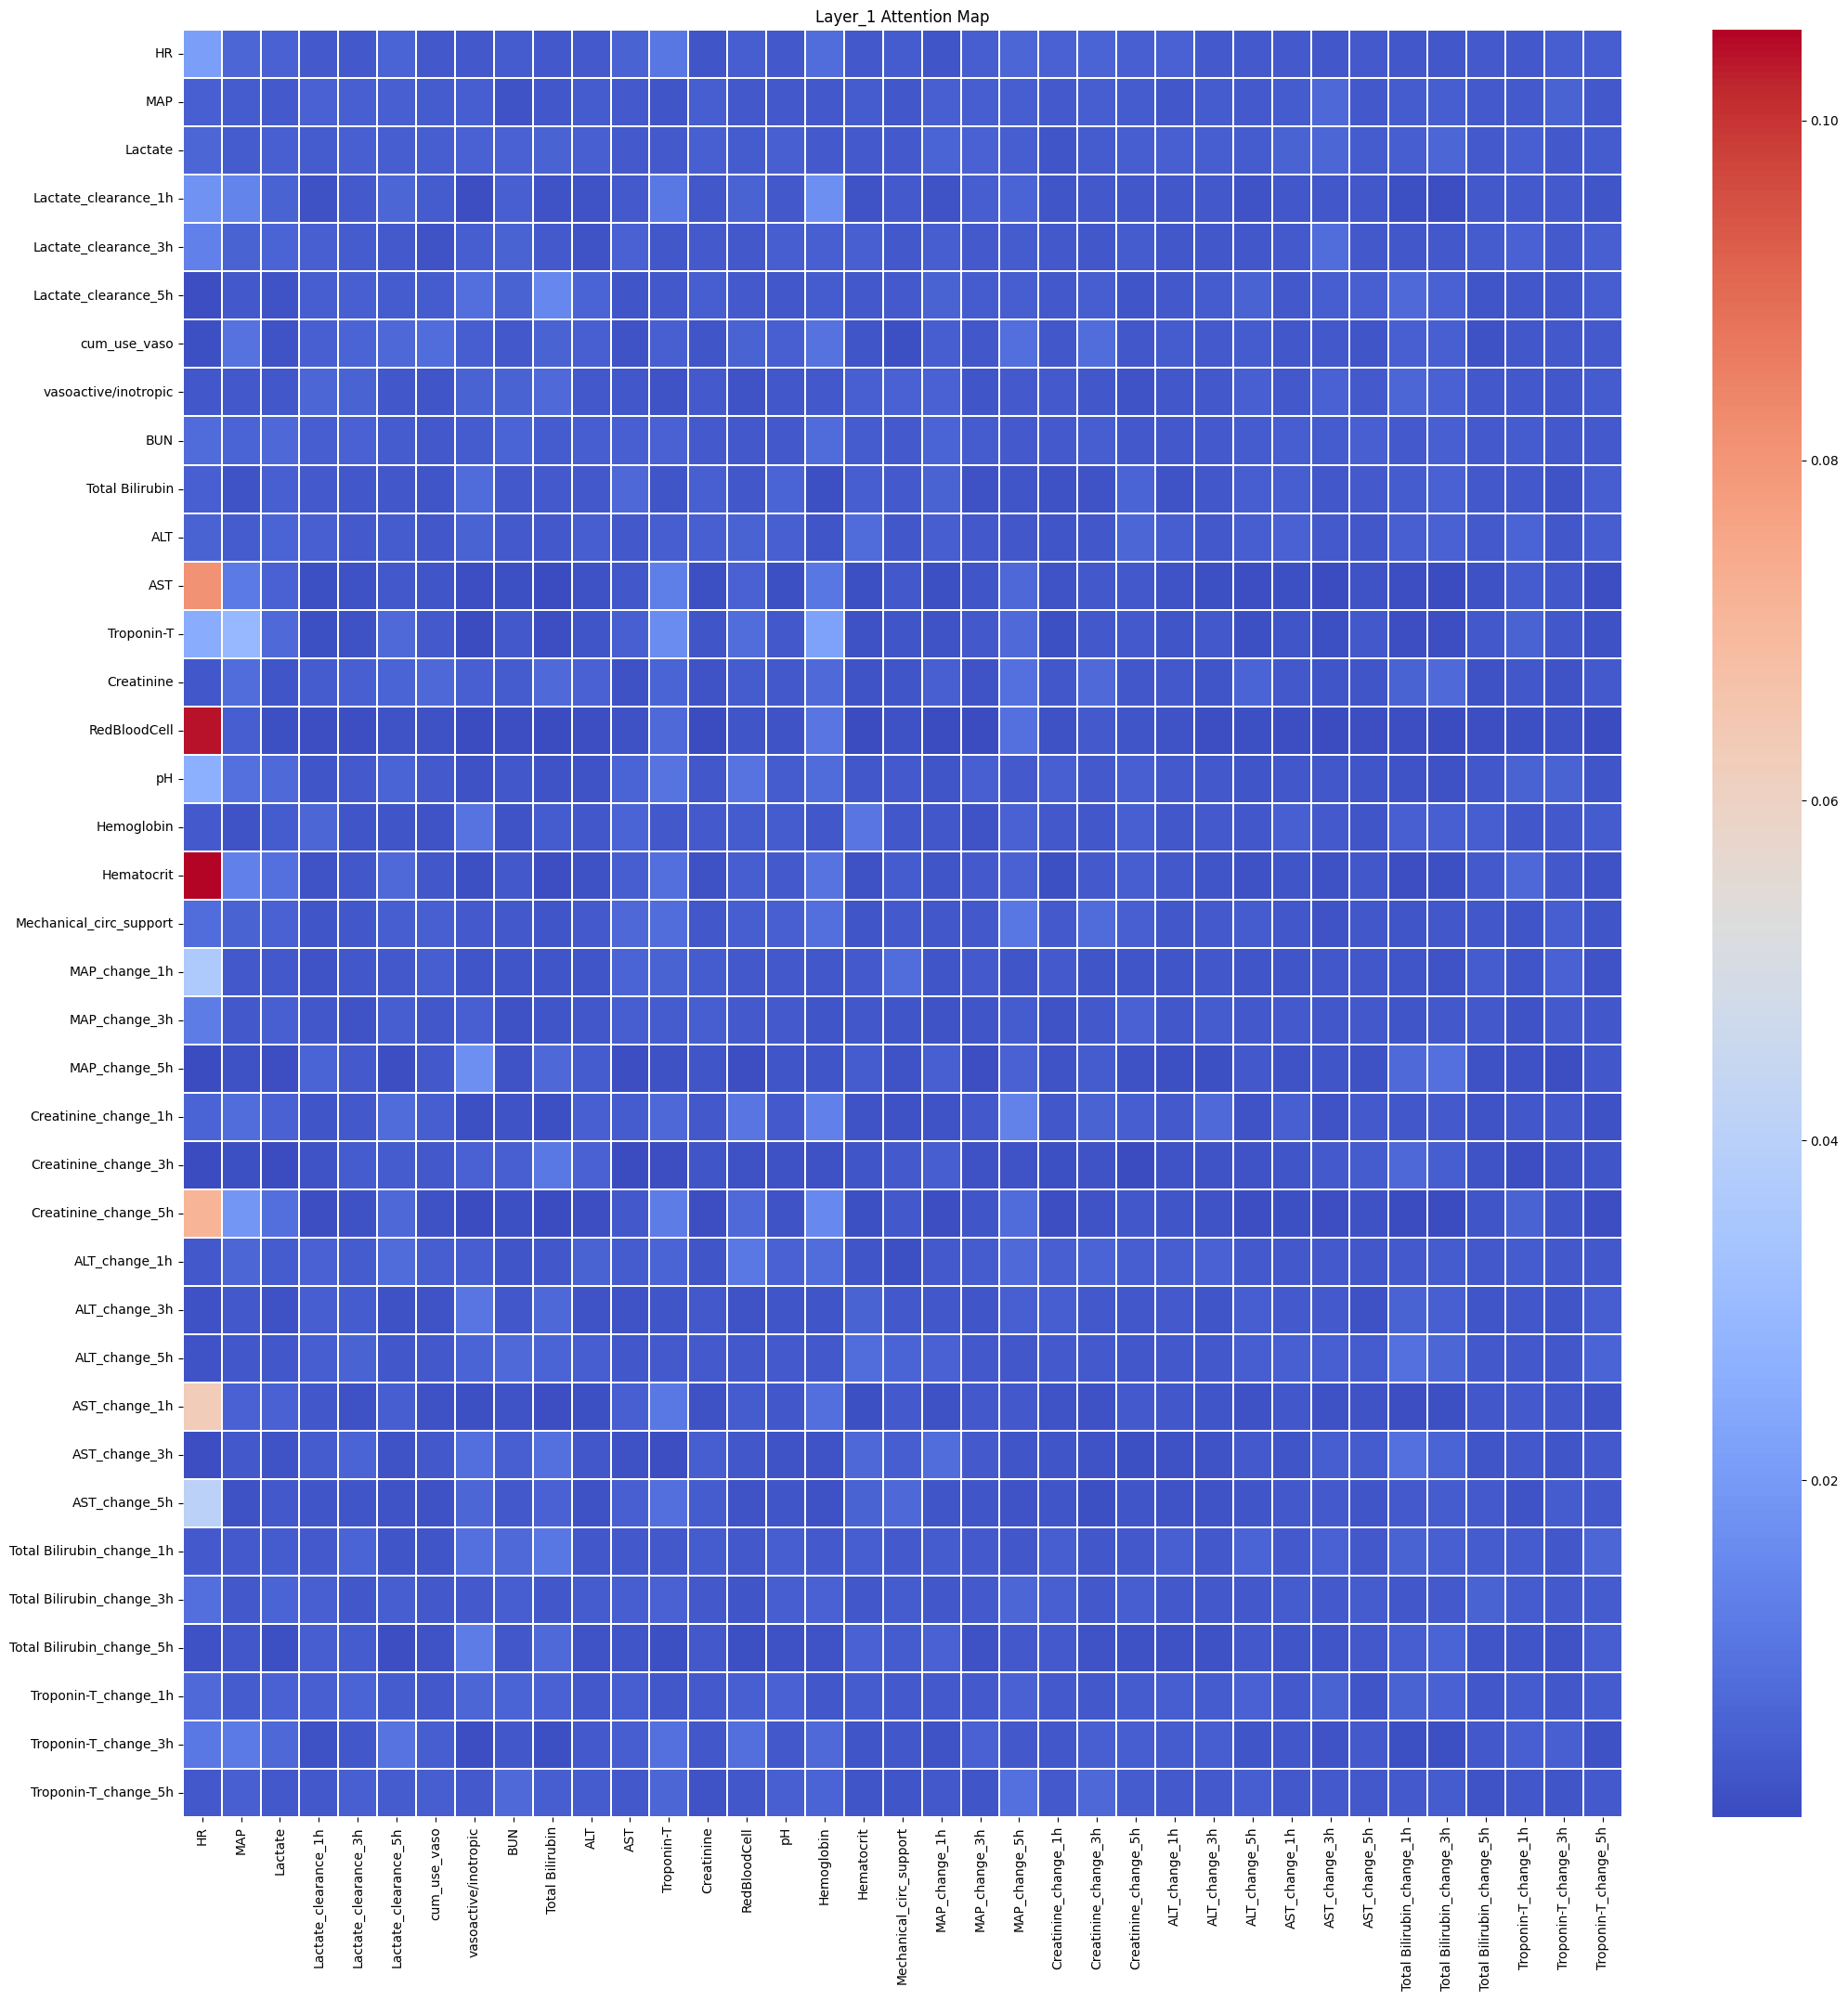

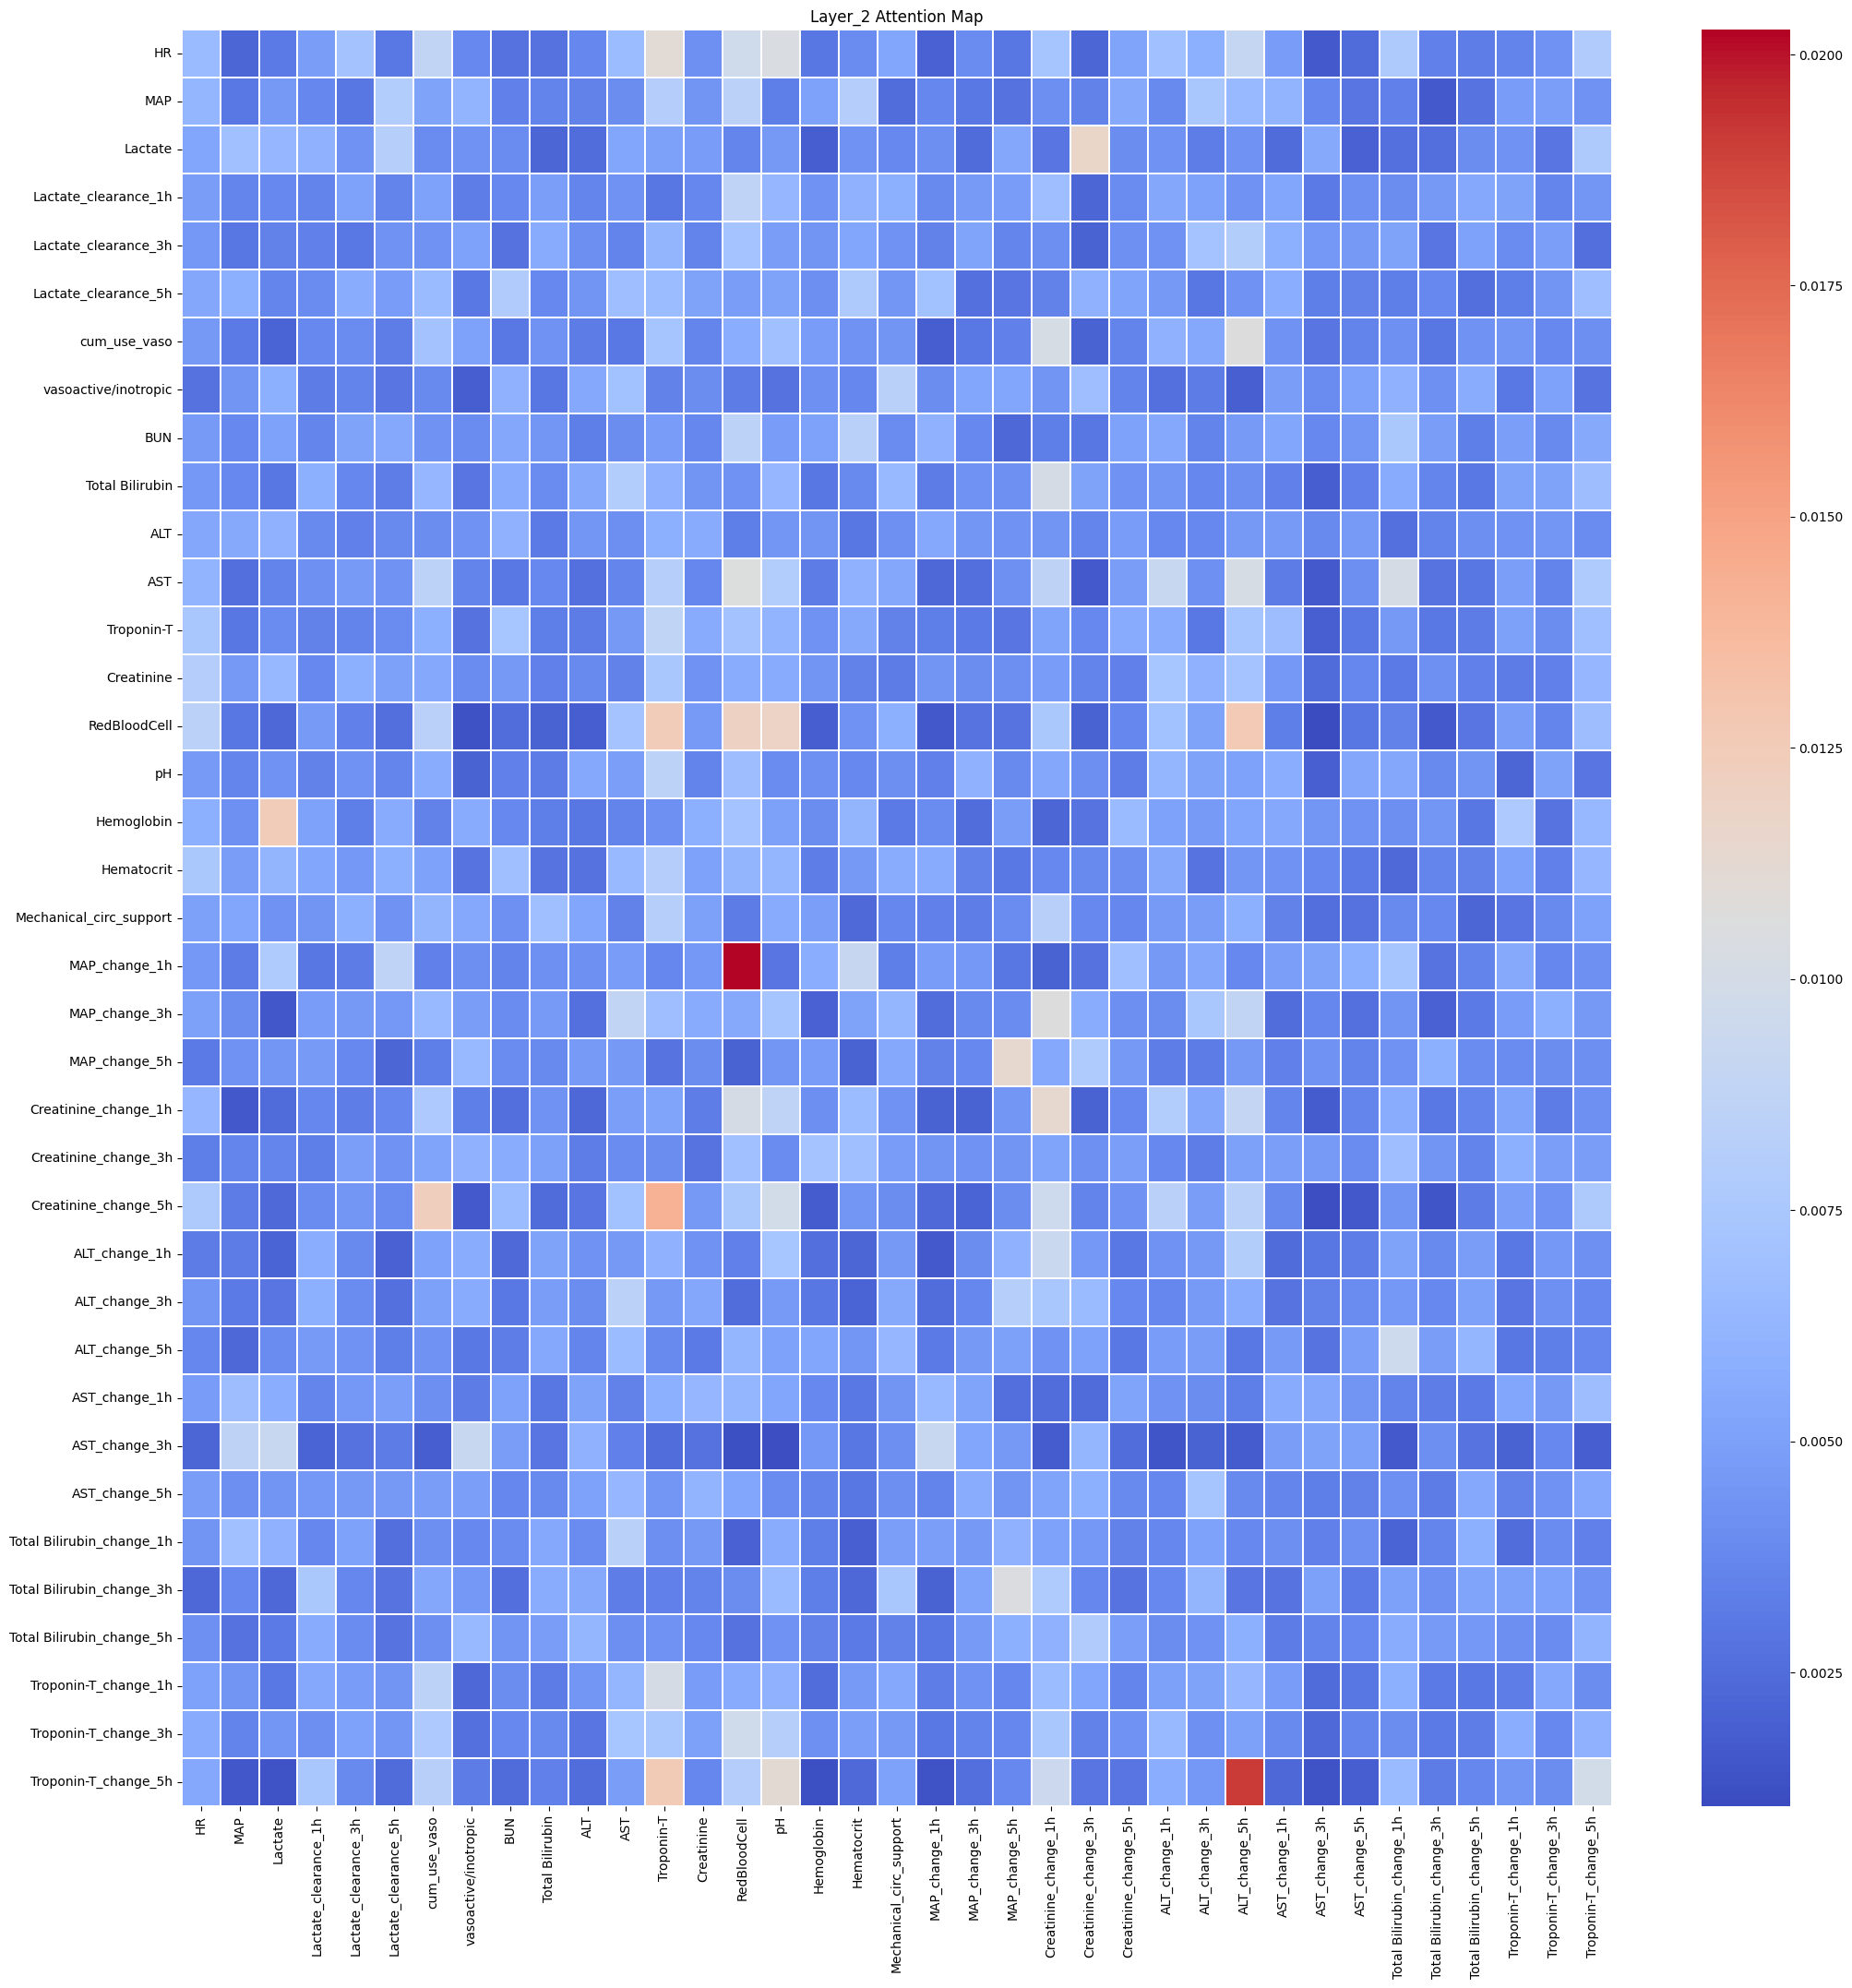

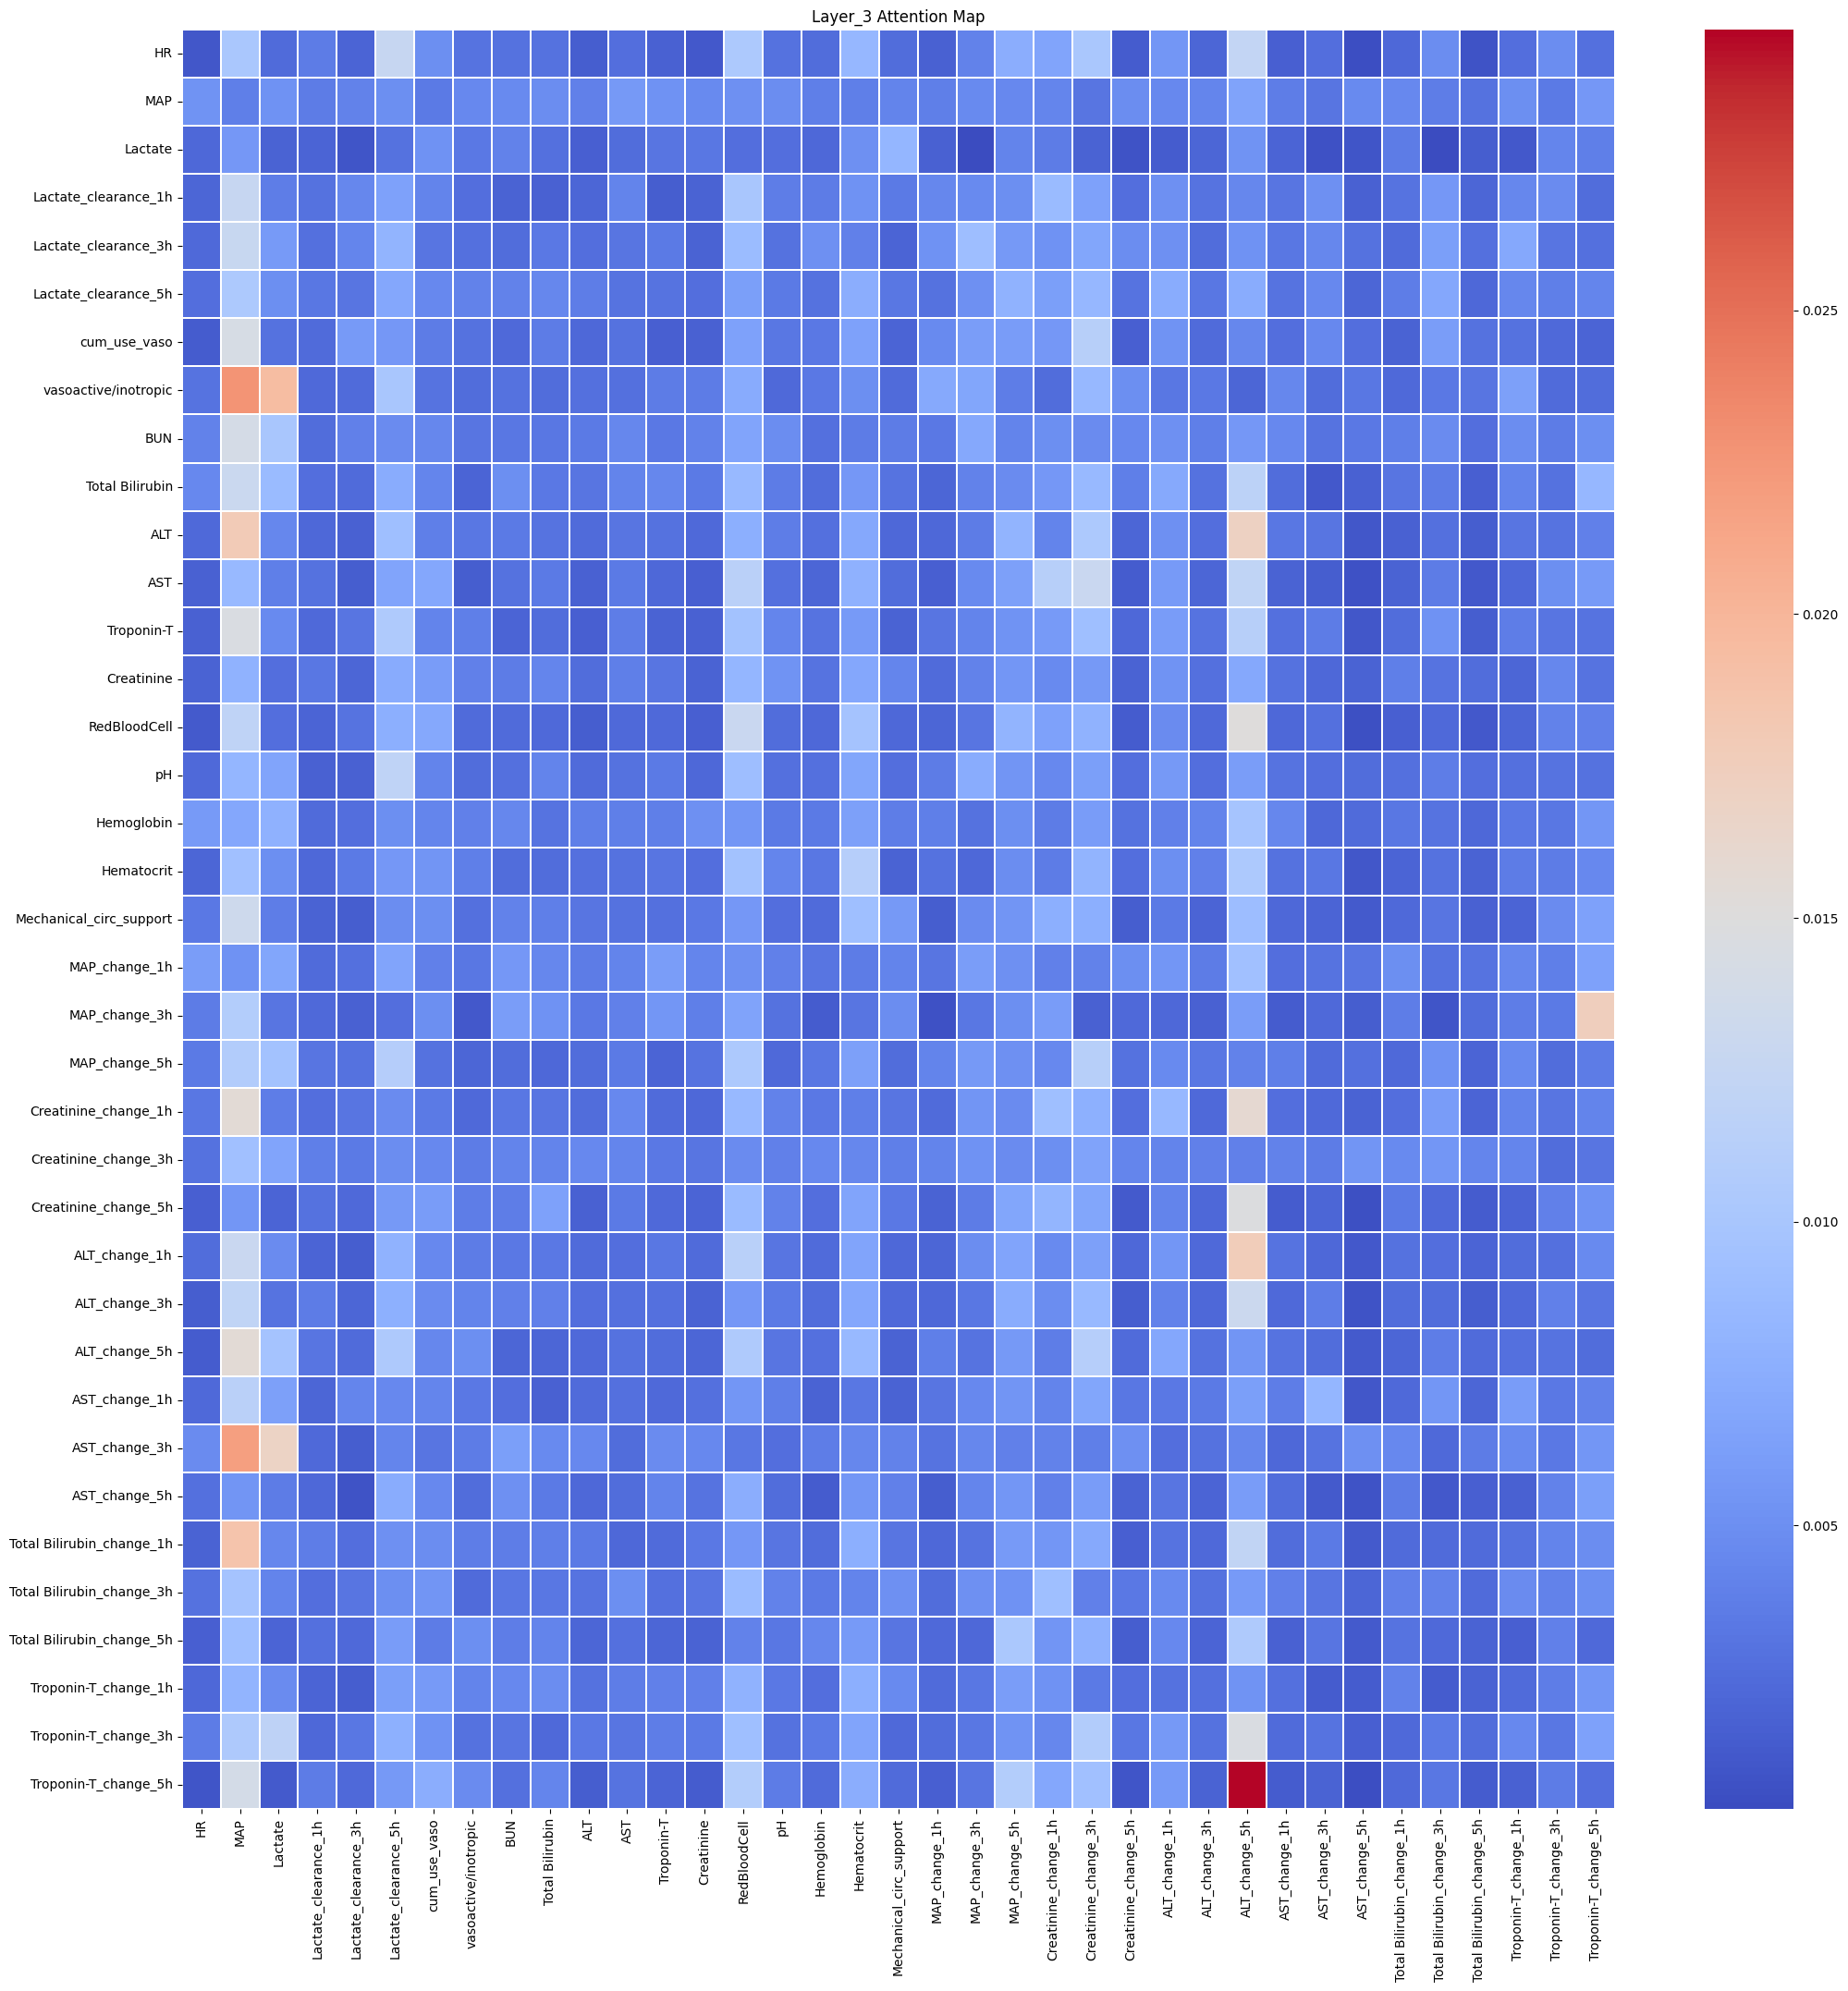

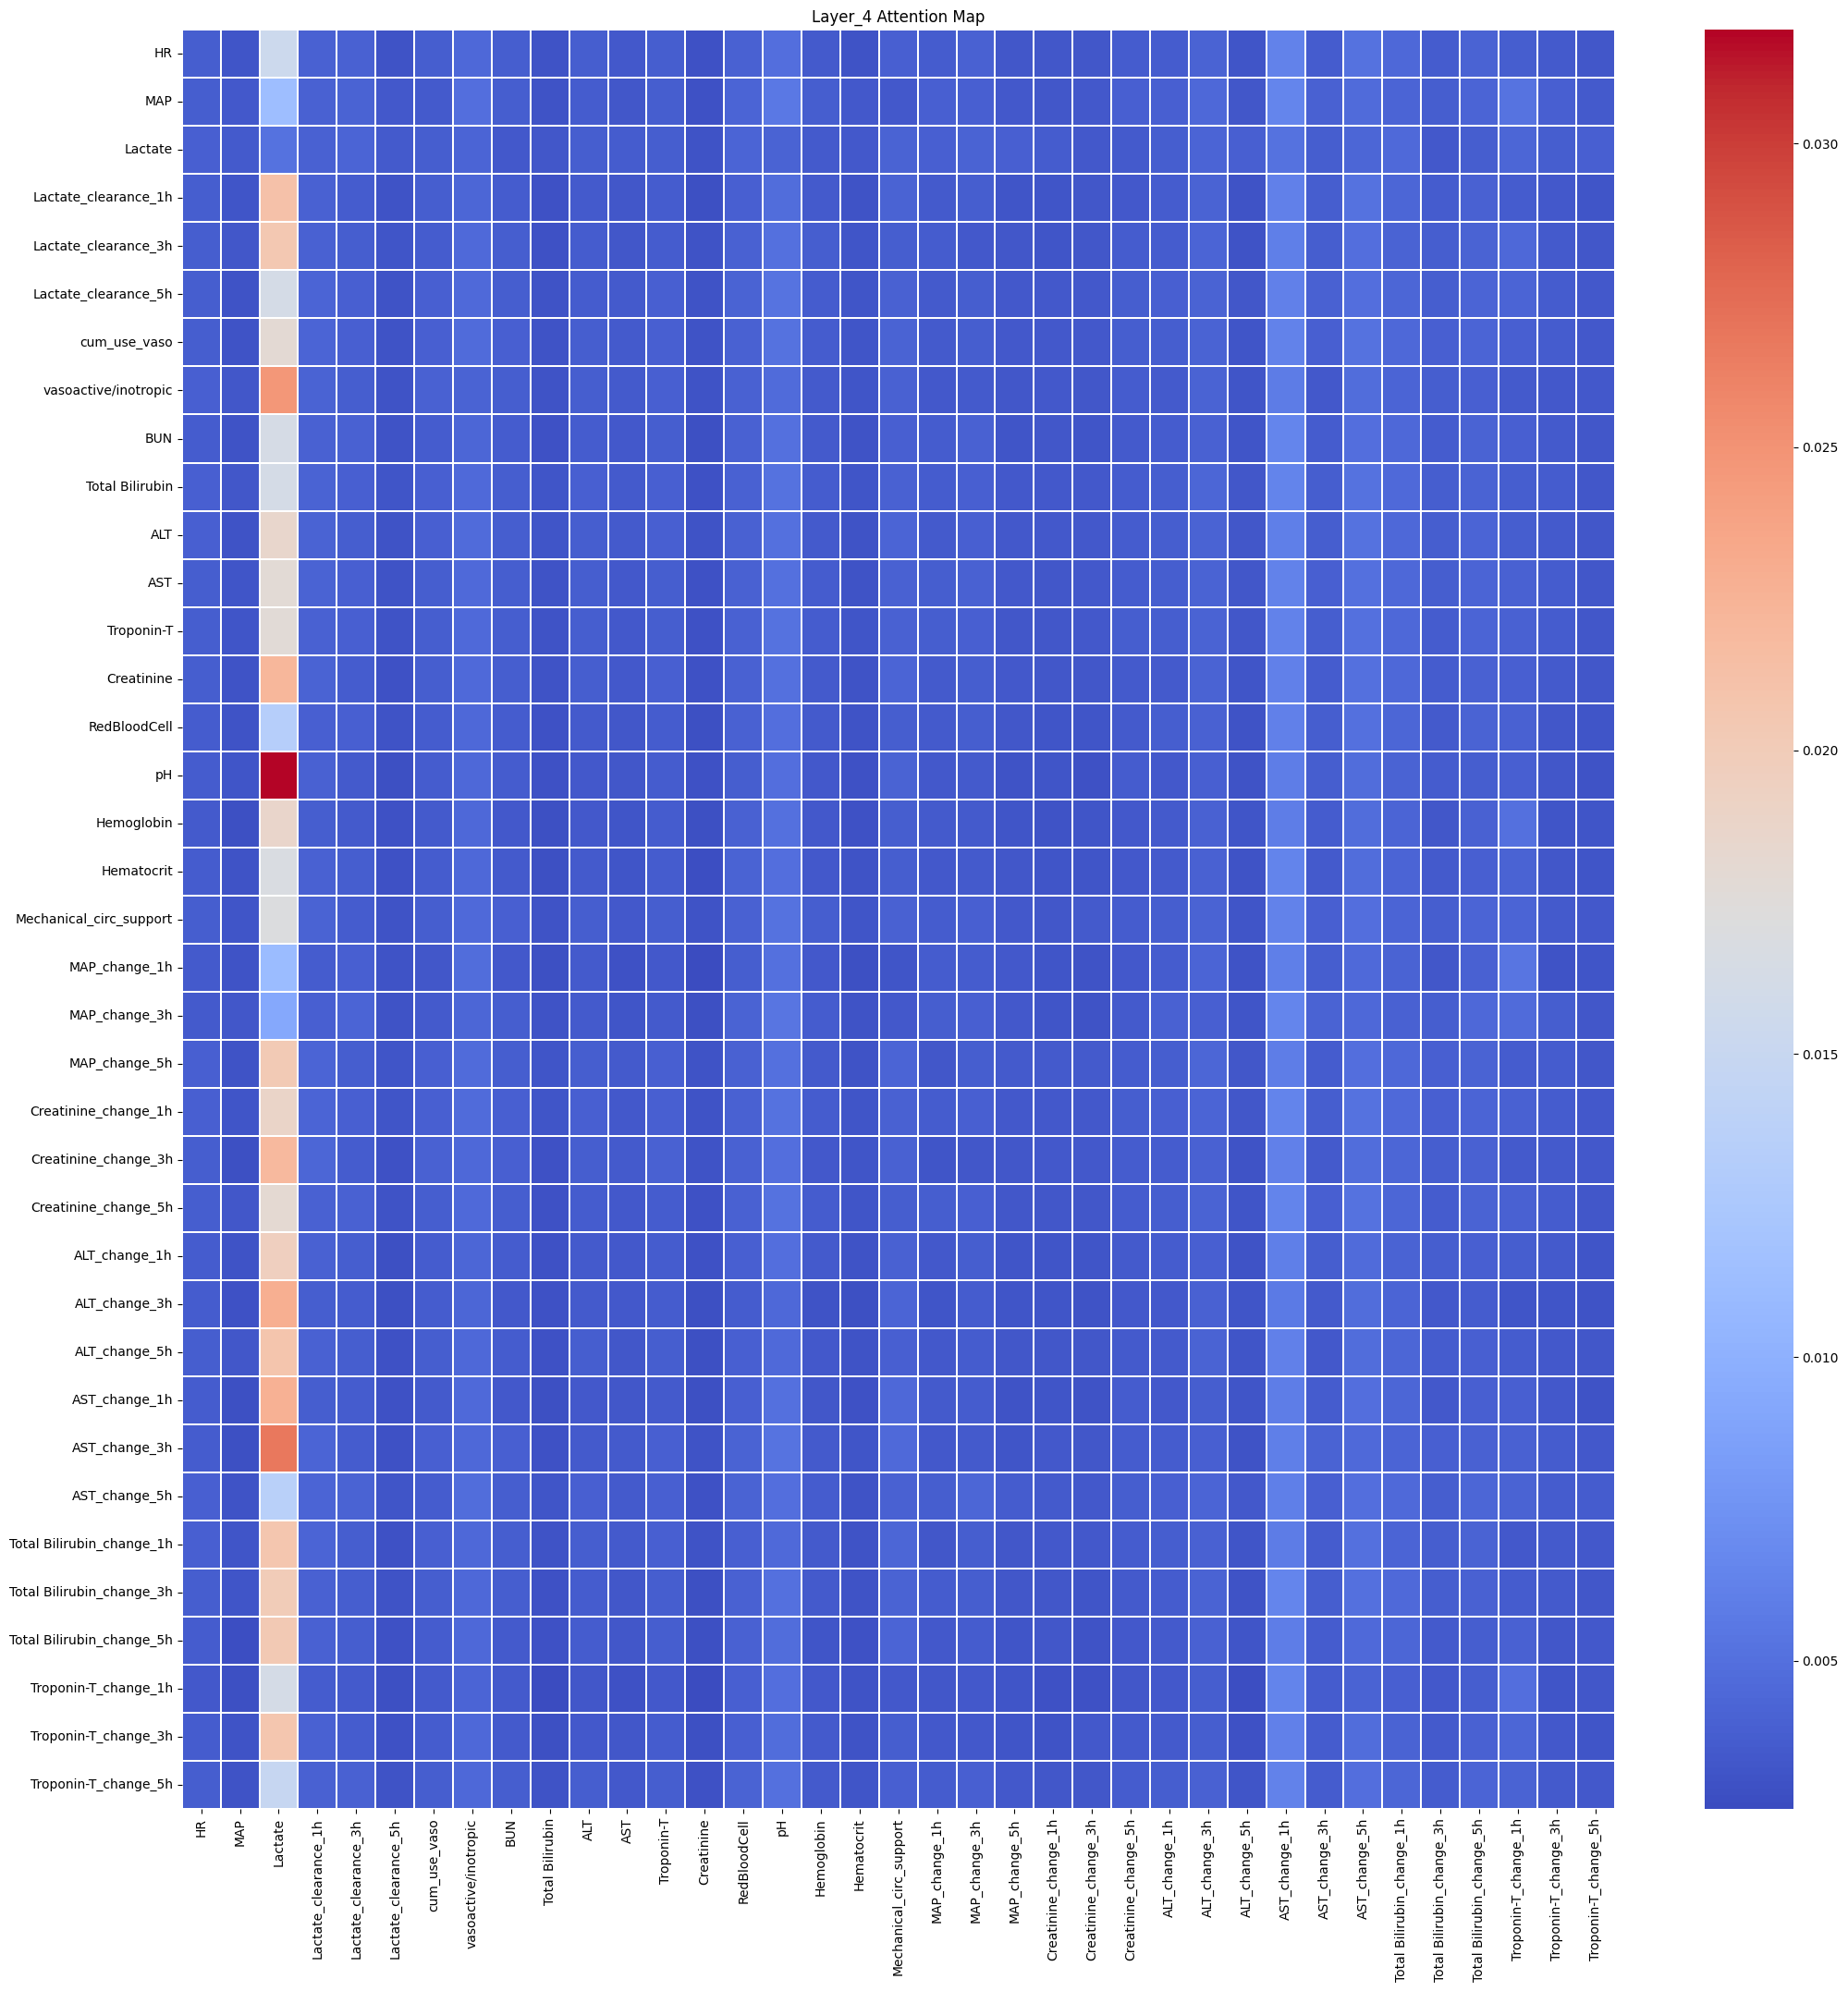

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for layer in range(valid_att.shape[0]):
    plt.figure(figsize=(25, 25))
    plt.title(f'Layer_{layer+1} Attention Map')
    
    # 평균 계산
    avg_att = np.mean(valid_att[layer, :, :, :], axis=0) #(219, 219)
    avg_att_focus = avg_att[col_indx, :][:, col_indx]
    # Heatmap 그리기
    sns.heatmap(avg_att_focus, cmap='coolwarm', 
                xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

In [24]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc
from timeit import default_timer as timer

gc.collect()

def attention_map_perclass(model_name, max_samples_per_class=5000):
    print('Start Getting the latent space vector (Valid sample)')
    start = time.time()

    model_name.eval()
    with torch.no_grad():
        label_valid_list = []
        # 클래스별 attention 데이터를 저장할 딕셔너리
        att_valid_dict = {}

        for num_iter, batch_data in enumerate(tqdm(loader_trn_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            _, att_valid = model_name(X_cat, X_num, True)

            # Latent 데이터와 레이블 저장
            label_valid_list.append(label.numpy())

            # 배치 내 각 샘플에 대해
            for i in range(label.size(0)):
                label_item = label[i].item()
                if att_valid_dict.get(label_item) is None:
                    att_valid_dict[label_item] = []

                if len(att_valid_dict[label_item]) < max_samples_per_class:
                    # 클래스별 attention 데이터 저장
                    # att_valid의 형태: (2, 배치크기, 2, 218, 218)
                    att_valid_dict[label_item].append(att_valid[:, i:i+1, :, :, :].cpu().numpy())

            gc.collect()


        # 클래스별 attention 데이터를 하나의 넘파이 배열로 변환
        att_valid_combined = {k: np.concatenate(v, axis=1) for k, v in att_valid_dict.items()}


    end = time.time()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return att_valid_combined

# 모델 실행
att = attention_map_perclass(model)


Start Getting the latent space vector (Valid sample)


100%|██████████| 15933/15933 [25:12<00:00, 10.53it/s]


End, Time consume (min): 28.36820029815038


In [25]:
columns = ['CLS_Token'] + mimic_train.df_cat.columns.tolist() + mimic_train.df_num.columns.tolist()

In [26]:

# focus_columns는 시각화하고자 하는 특정 컬럼들의 인덱스 리스트
focus_col_name = ['HR', 'MAP', 'Lactate', 'Lactate_clearance_1h',
'Lactate_clearance_3h', 'Lactate_clearance_5h', 'cum_use_vaso','vasoactive/inotropic', 'Alkaline_phosphatase',
'BUN','Total Bilirubin', 'ALT', 'AST', 'Troponin-T', 'Creatinine','RedBloodCell', 'pH', 'Hemoglobin', 'Hematocrit',
'Mechanical_circ_support', 'MAP_change_1h', 'MAP_change_3h', 'MAP_change_5h',
'Creatinine_change_1h', 'Creatinine_change_3h', 'Creatinine_change_5h', 'ALT_change_1h', 'ALT_change_3h', 'ALT_change_5h','AST_change_1h', 'AST_change_3h', 'AST_change_5h',
'Total Bilirubin_change_1h', 'Total Bilirubin_change_3h', 'Total Bilirubin_change_5h', 'Troponin-T_change_1h', 'Troponin-T_change_3h', 'Troponin-T_change_5h']

focus_columns = [columns.index(col) for col in focus_col_name if col in columns]


# 필요한 컬럼 이름만 추출
focus_columns_names = [columns[i] for i in focus_columns]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_per_class(valid_att, focus_columns, focus_columns_names):
    for class_label, class_data in valid_att.items():
        for layer in range(class_data.shape[0]):
            # 5는 head의 개수, 5000은 샘플의 수, 218x218는 attention 행렬의 크기
            # 형태: (4, 5000, 5, 218, 218)
        
            attention_head = class_data[layer, :, 0, :, :]  # 형태: (5000, 218, 218)
            
            # focus_columns 인덱스를 사용하여 정사각형 행렬을 선택
            # np.ix_ 함수는 주어진 각 배열을 행과 열의 인덱스로 변환하여 정사각형 행렬을 선택하는 데 사용
            ixgrid = np.ix_(focus_columns, focus_columns)
            attention_focus = attention_head[:, ixgrid[0], ixgrid[1]]  # 형태: (5000, focus_columns 길이, focus_columns 길이)
            
            # 샘플 차원에 대한 평균을 계산하여 평균 attention 행렬을 얻음
            attention_focus_avg = np.mean(attention_focus, axis=0)
            
            plt.figure(figsize=(10, 10))
            plt.title(f'Class {class_label} - Layer {layer+1} Attention Map')
            sns.heatmap(attention_focus_avg, cmap='coolwarm',
                        xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.savefig(f'./result/Class_{class_label}_Layer_{layer+1}_Attention_Map.png')

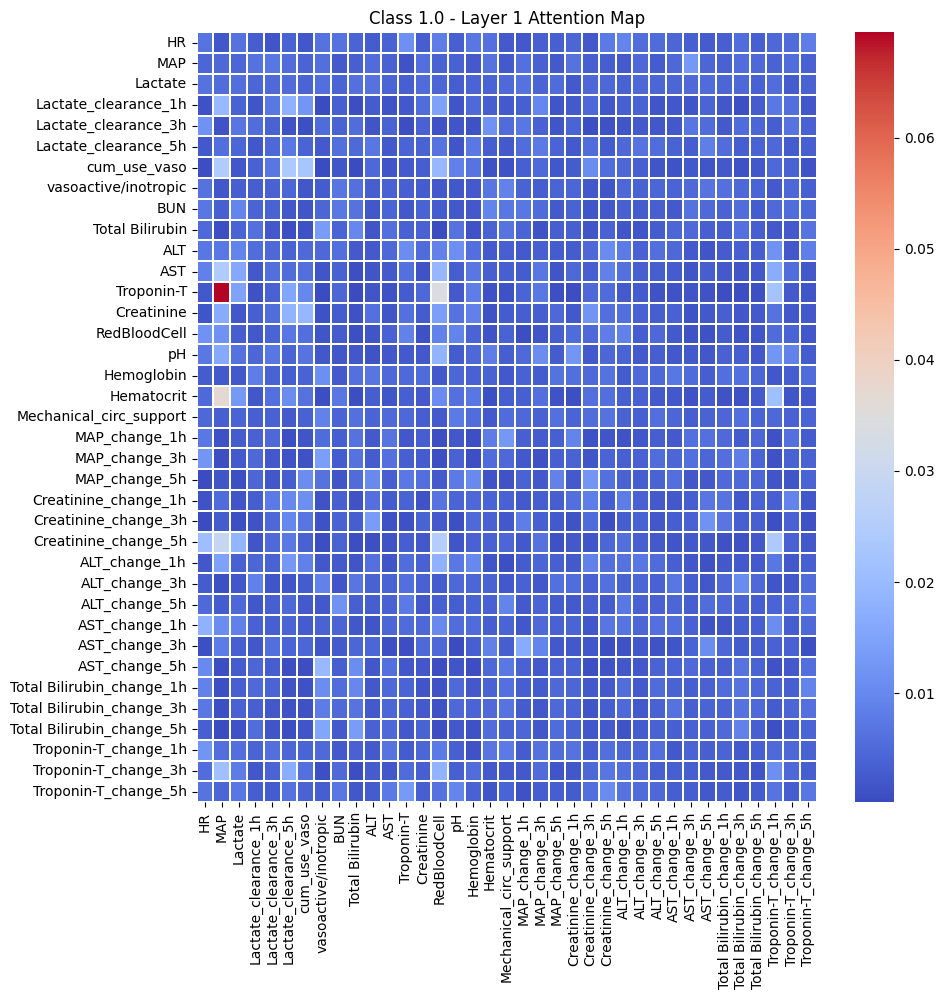

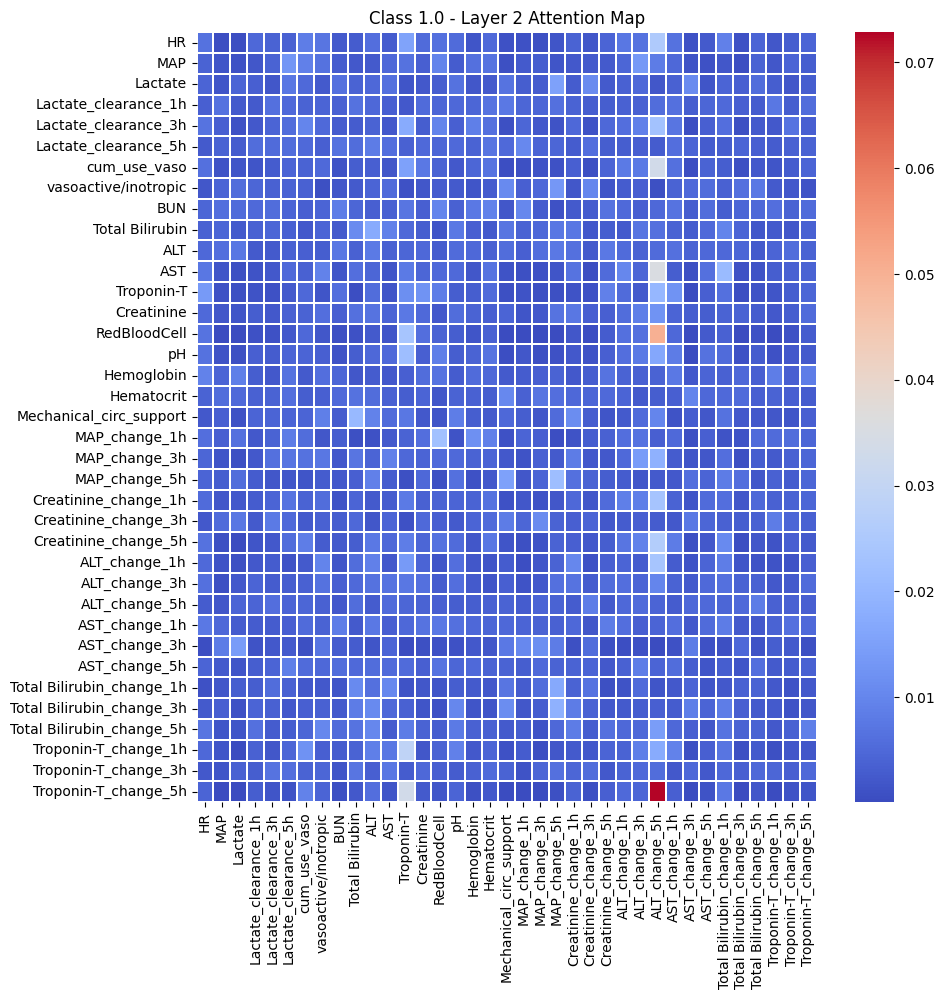

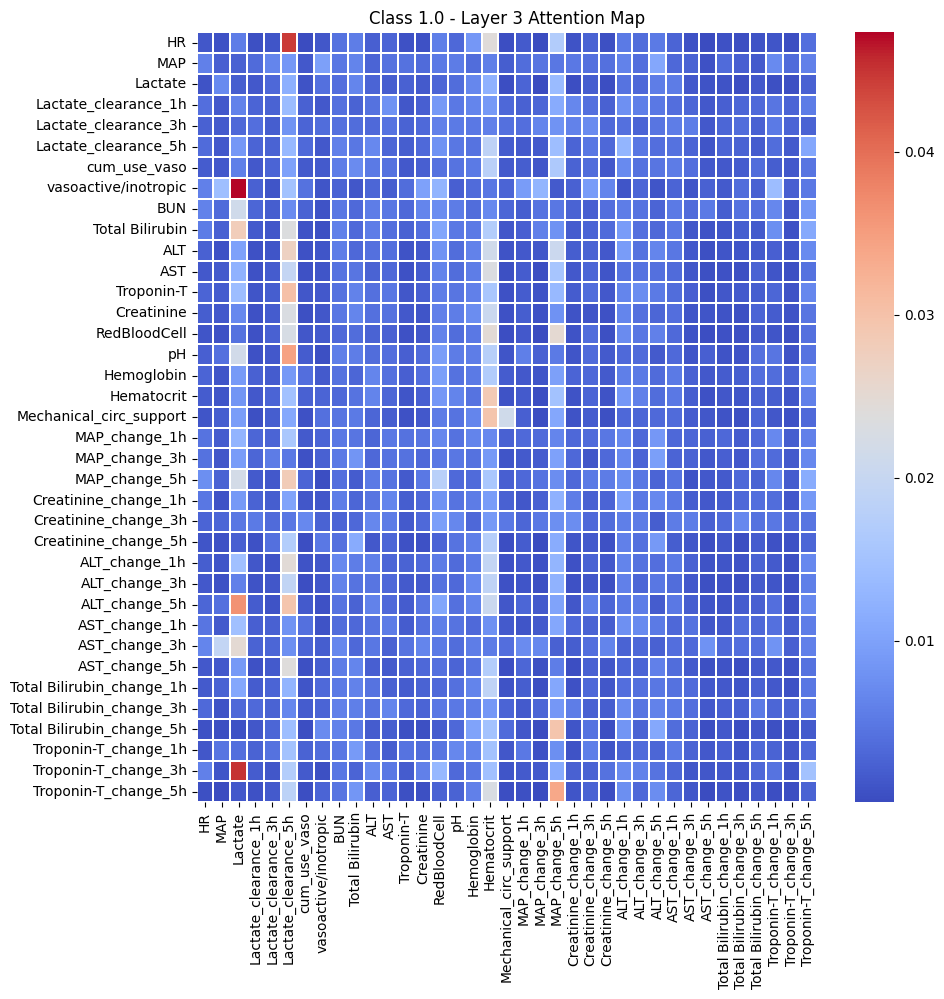

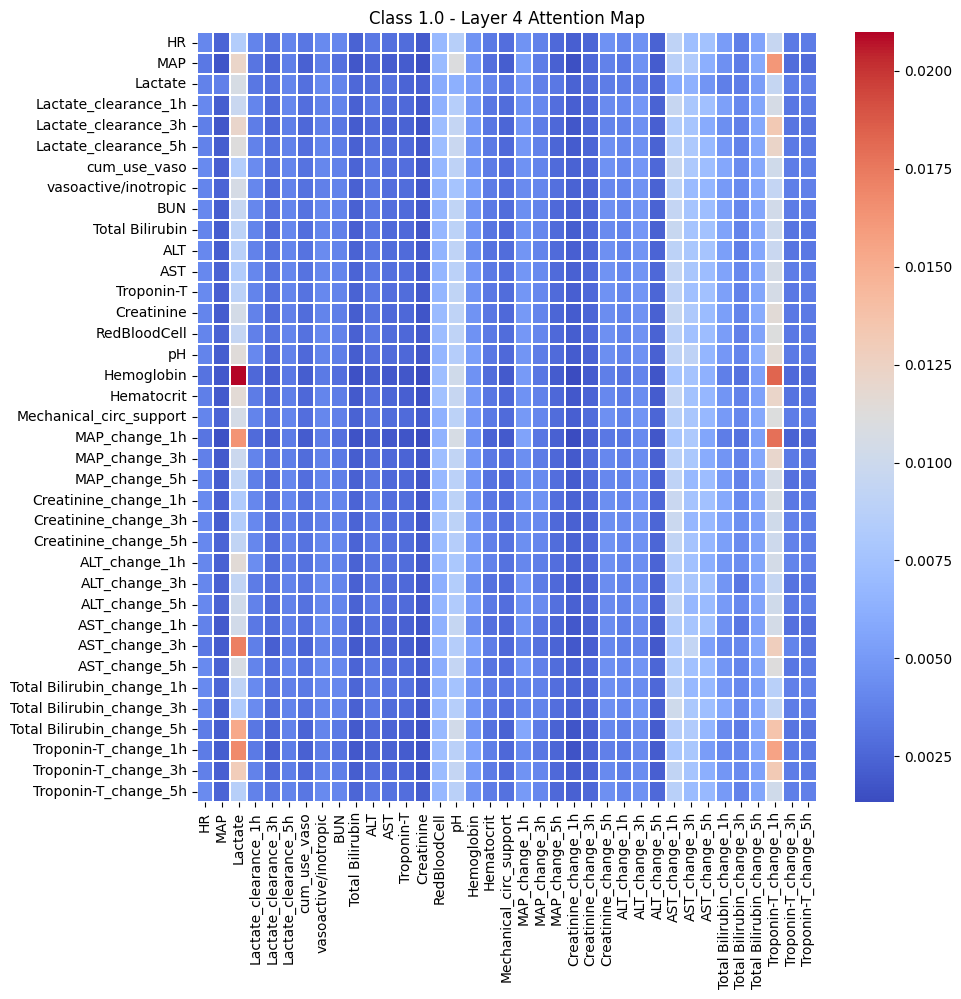

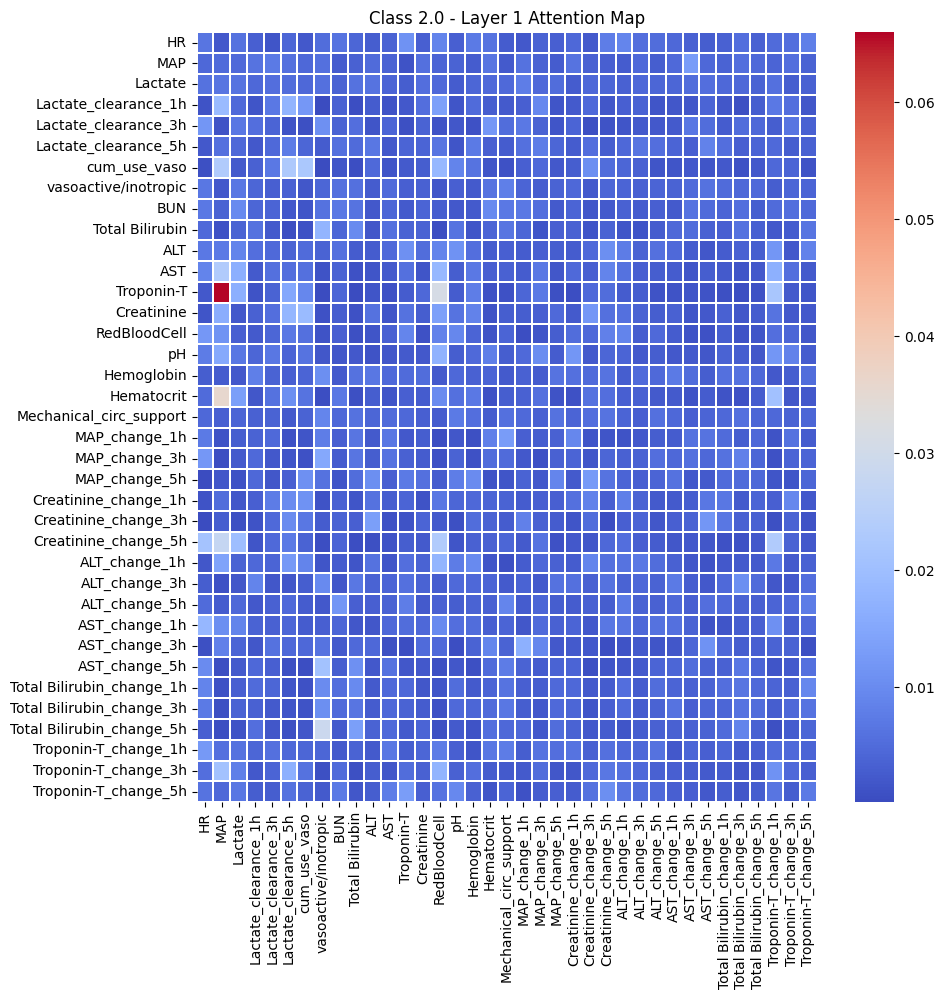

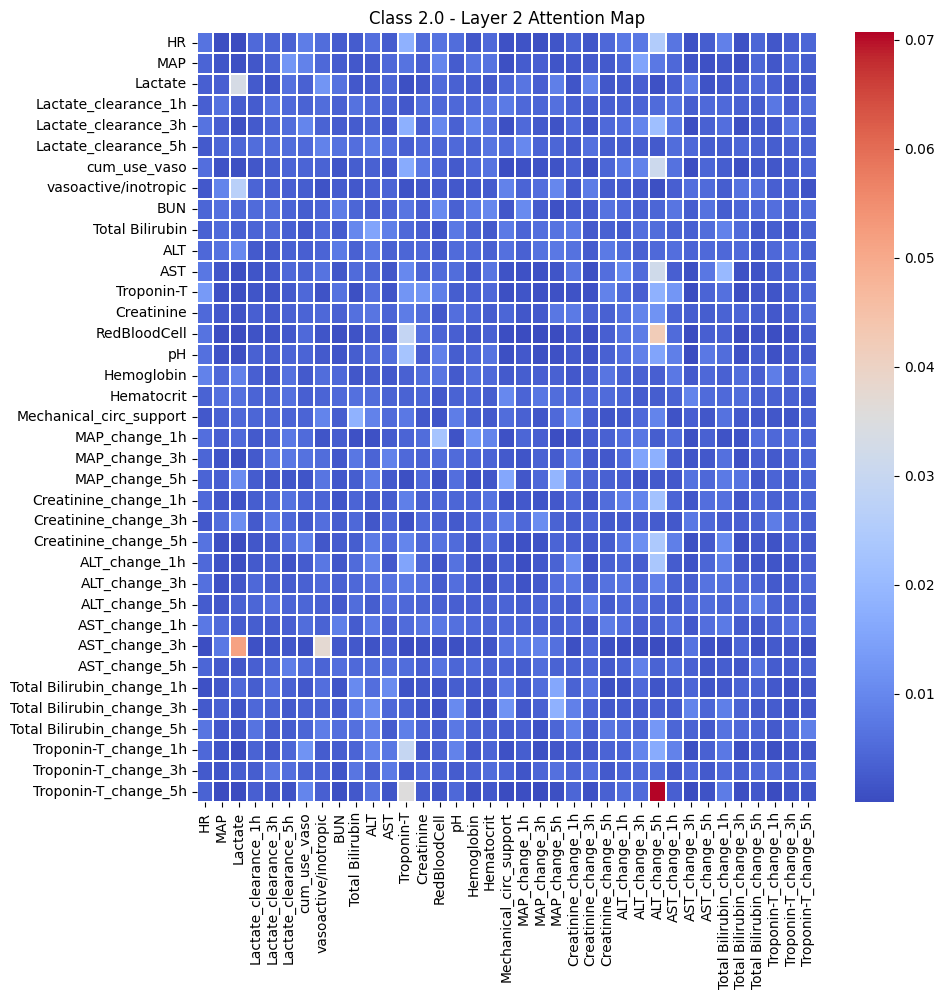

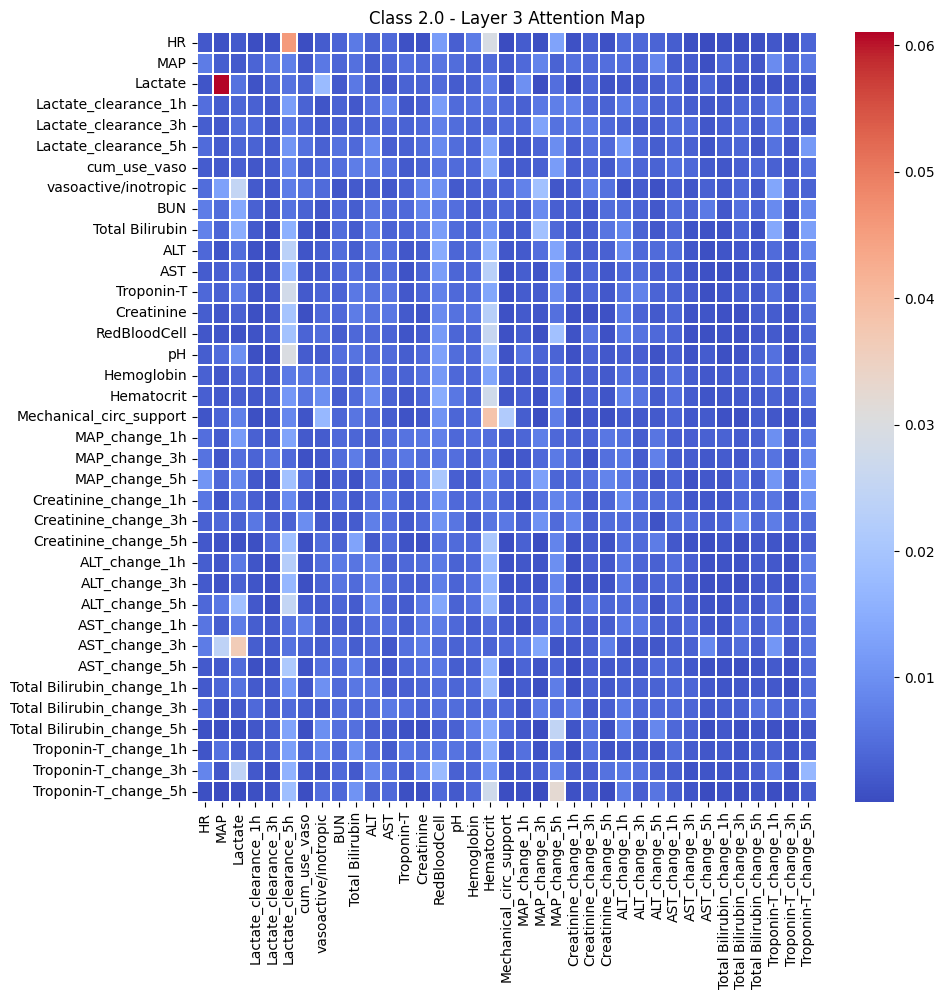

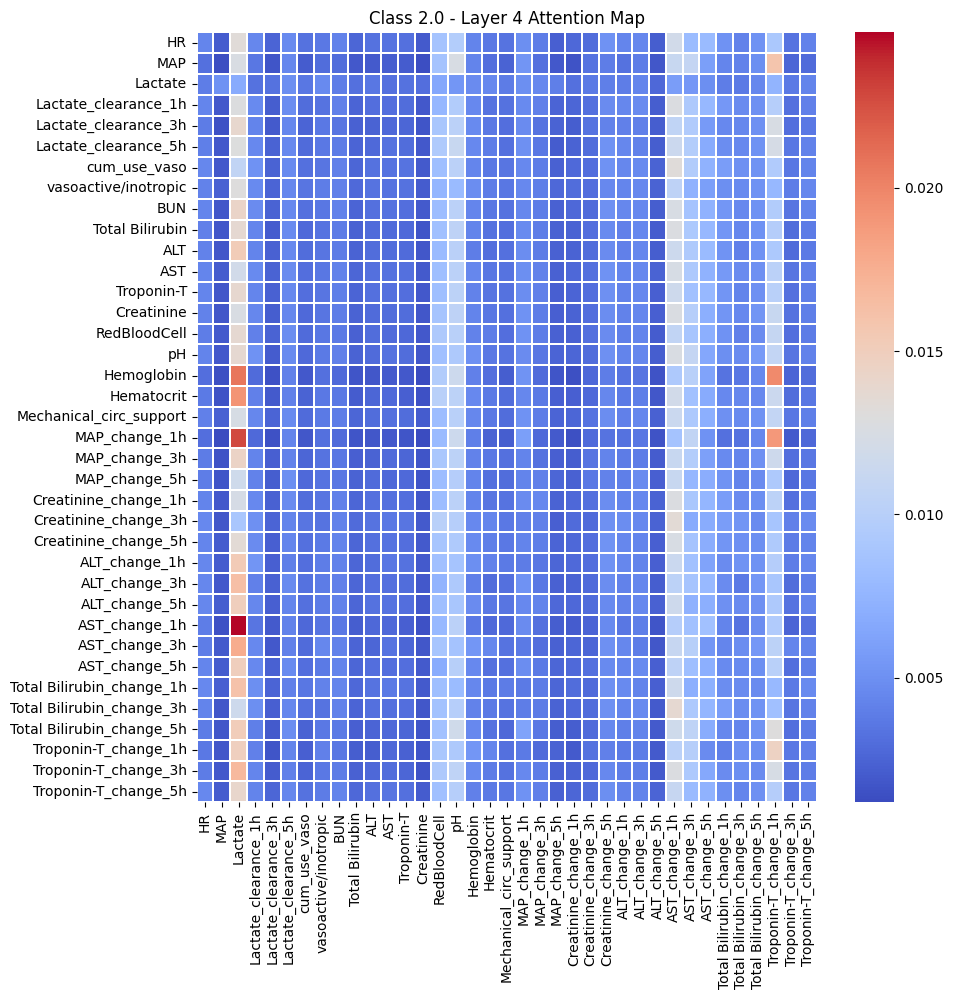

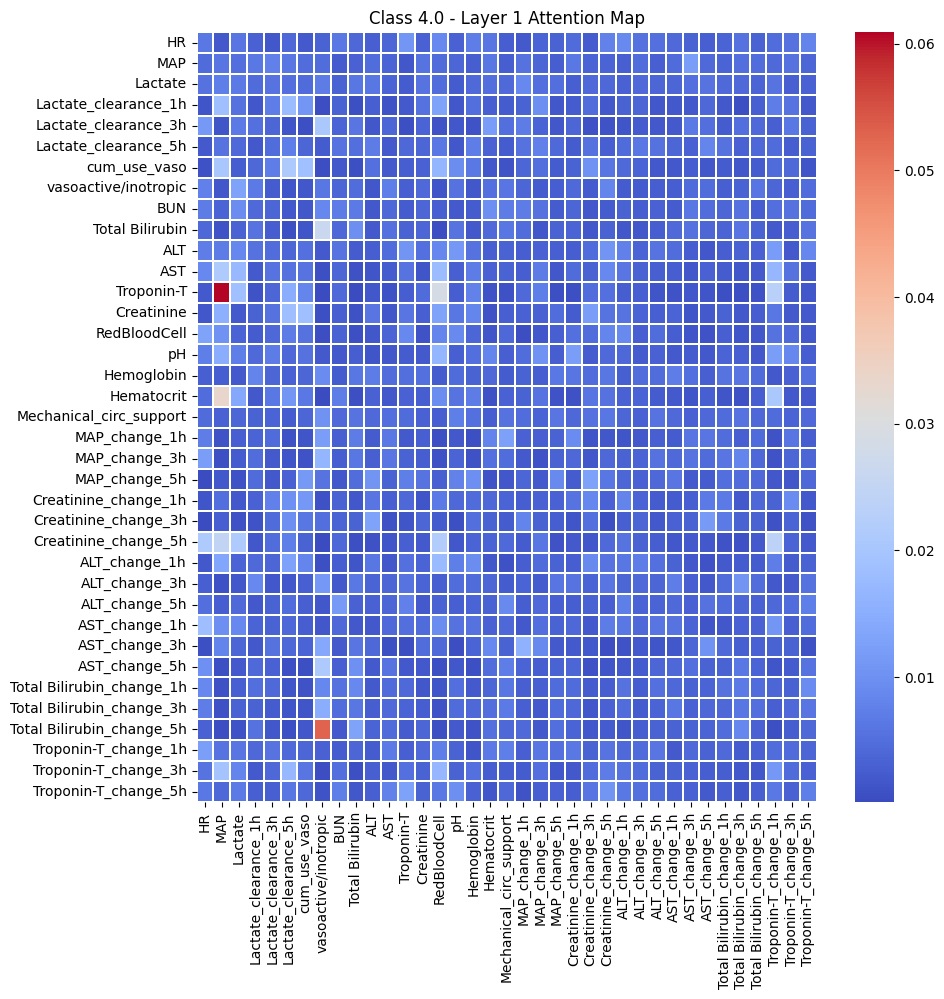

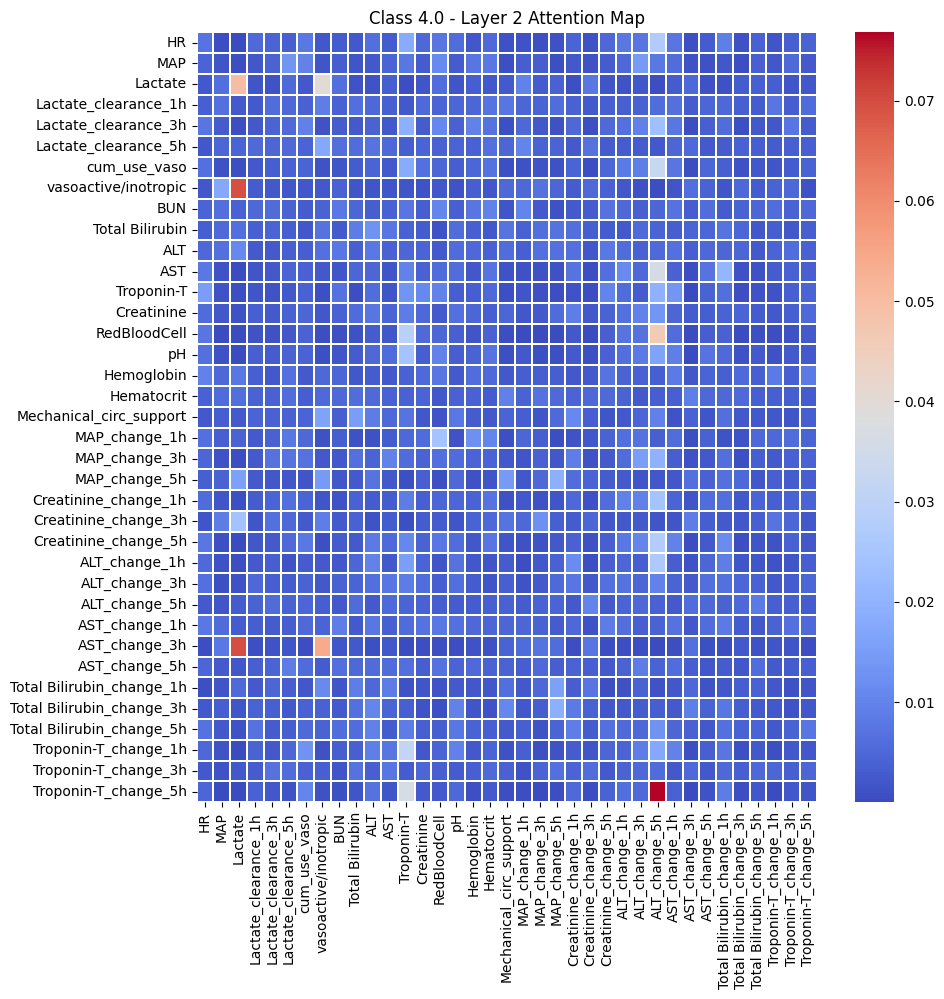

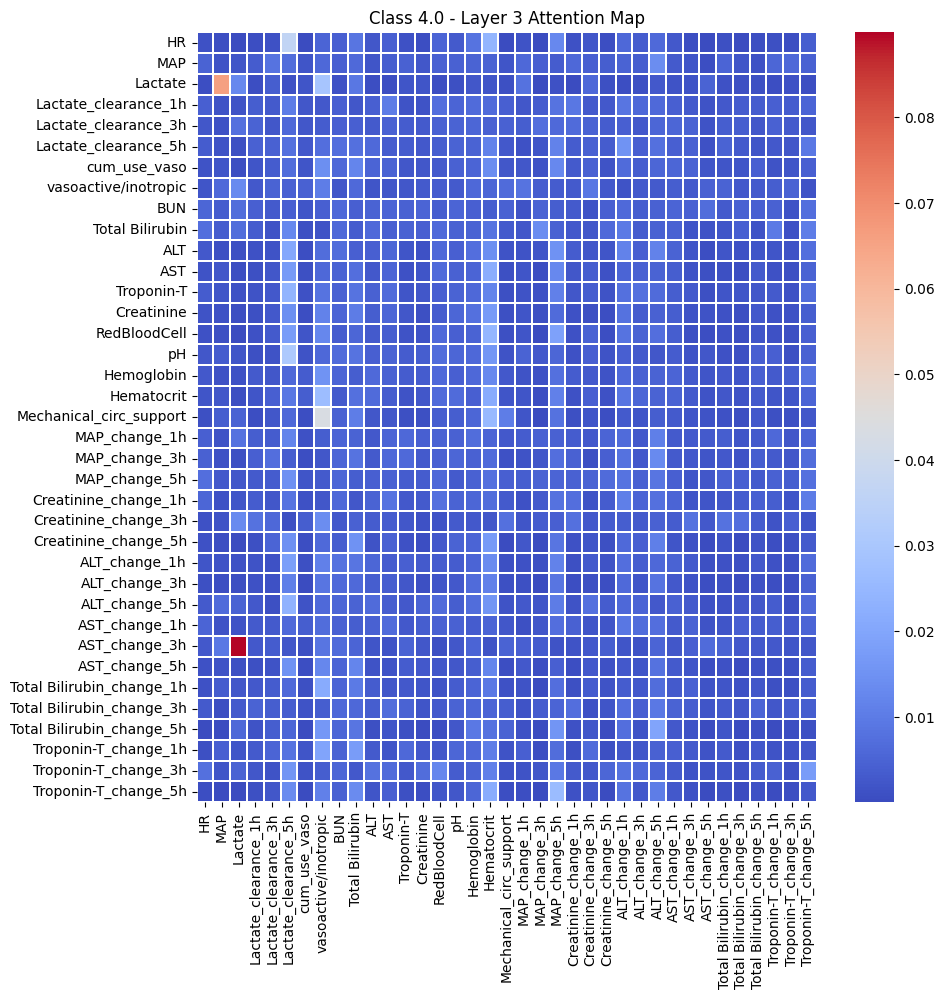

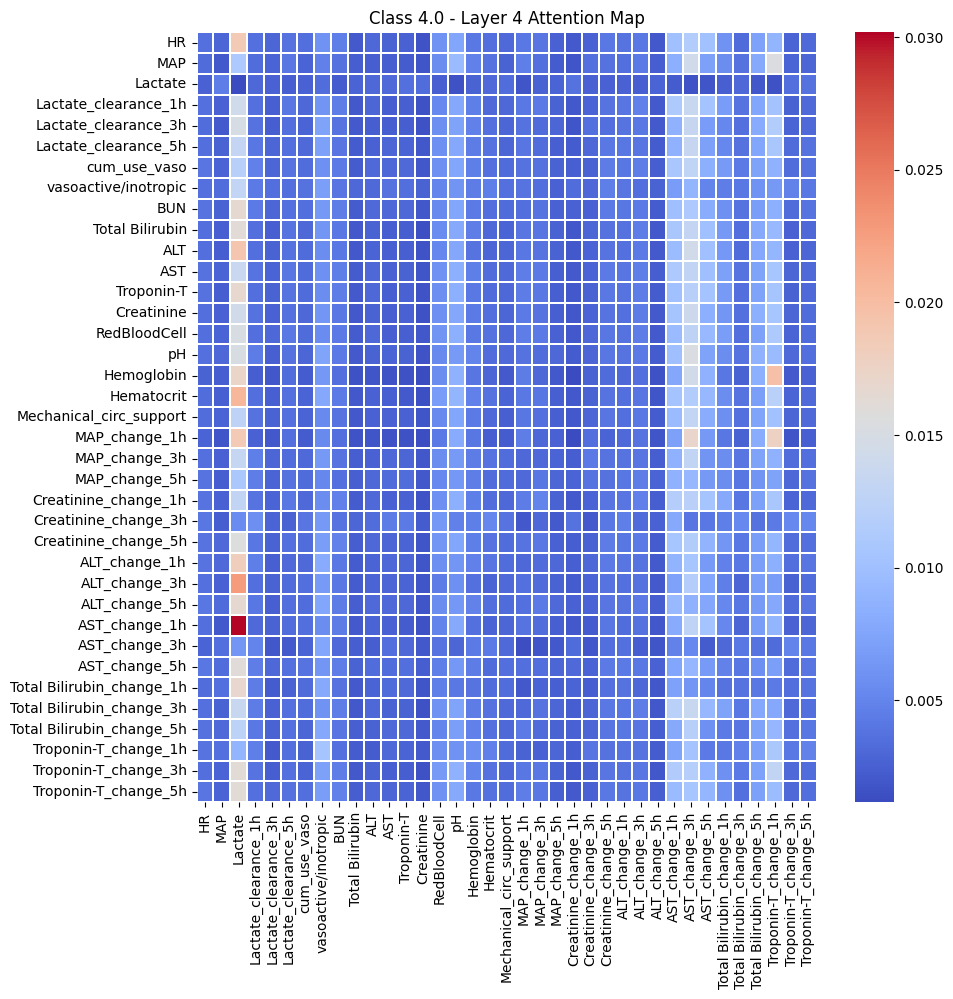

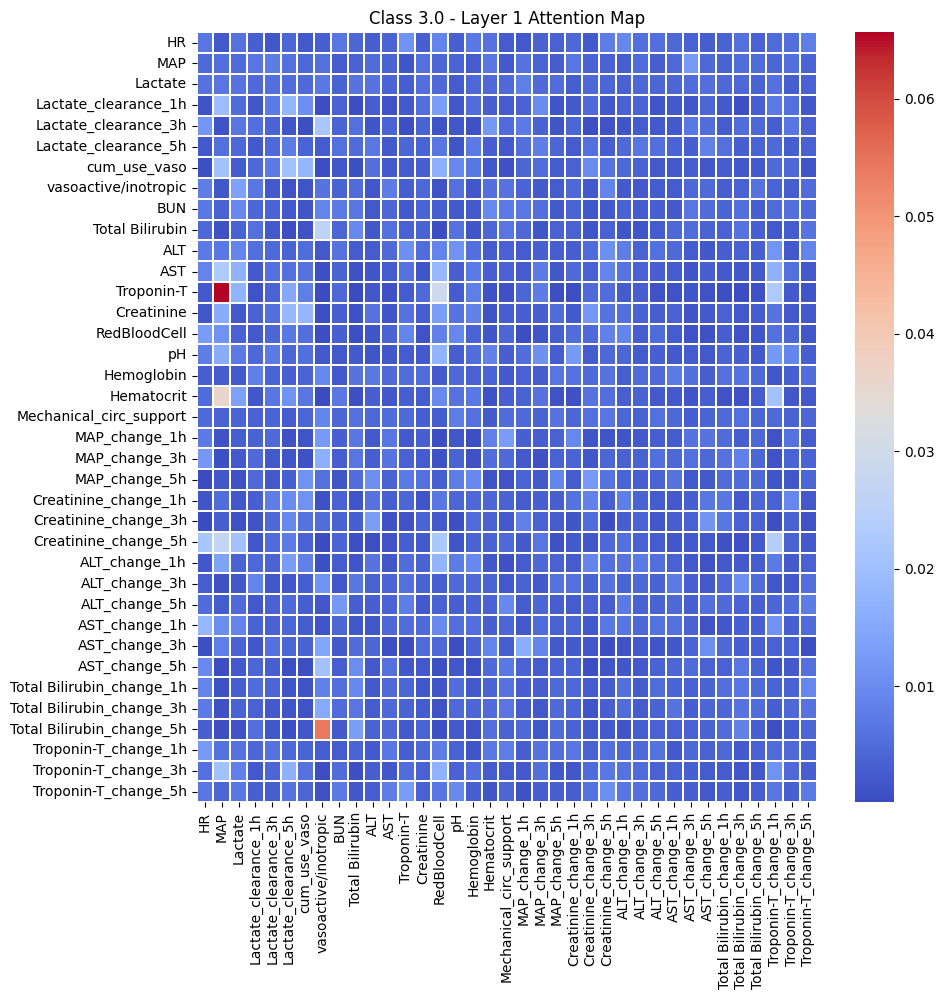

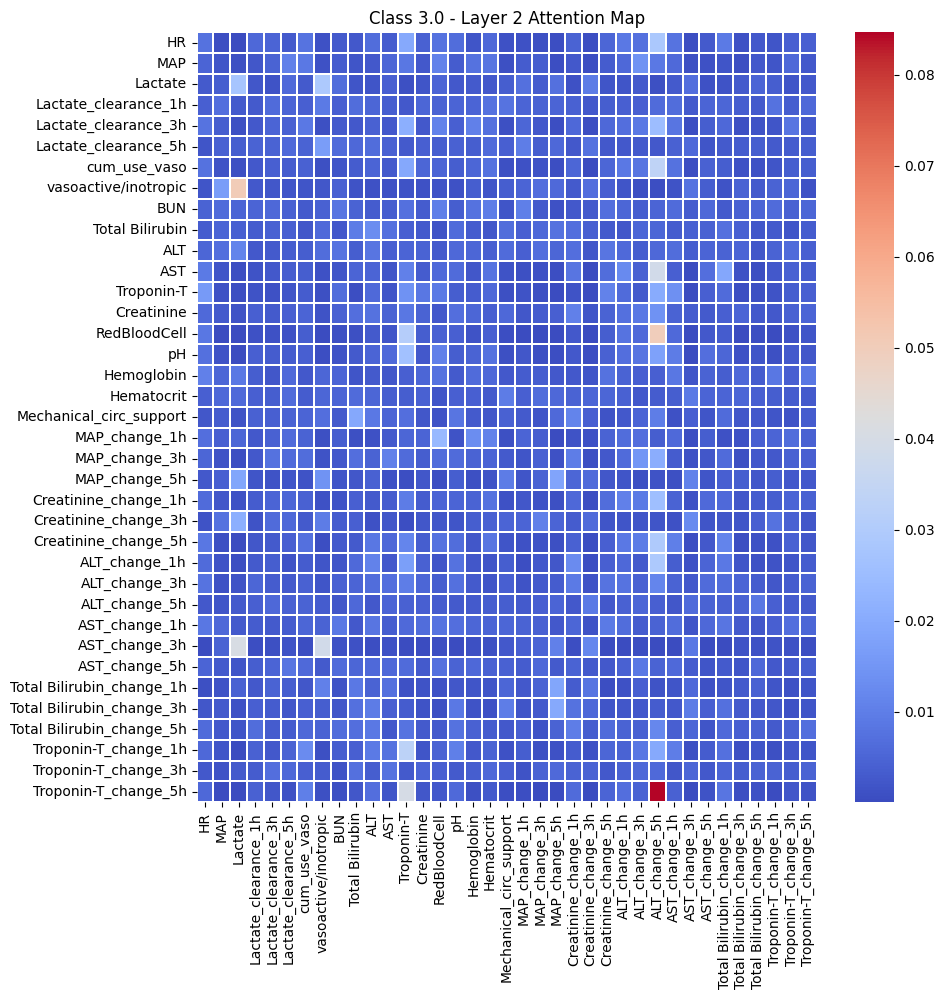

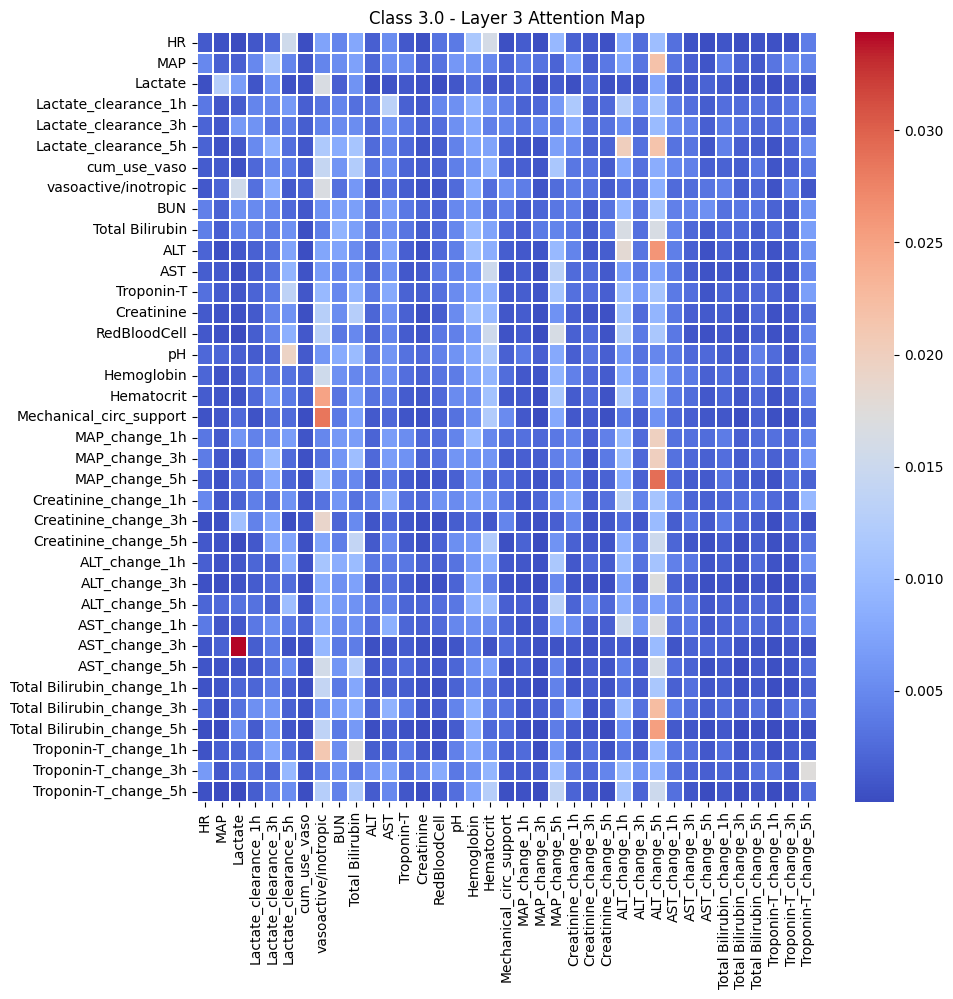

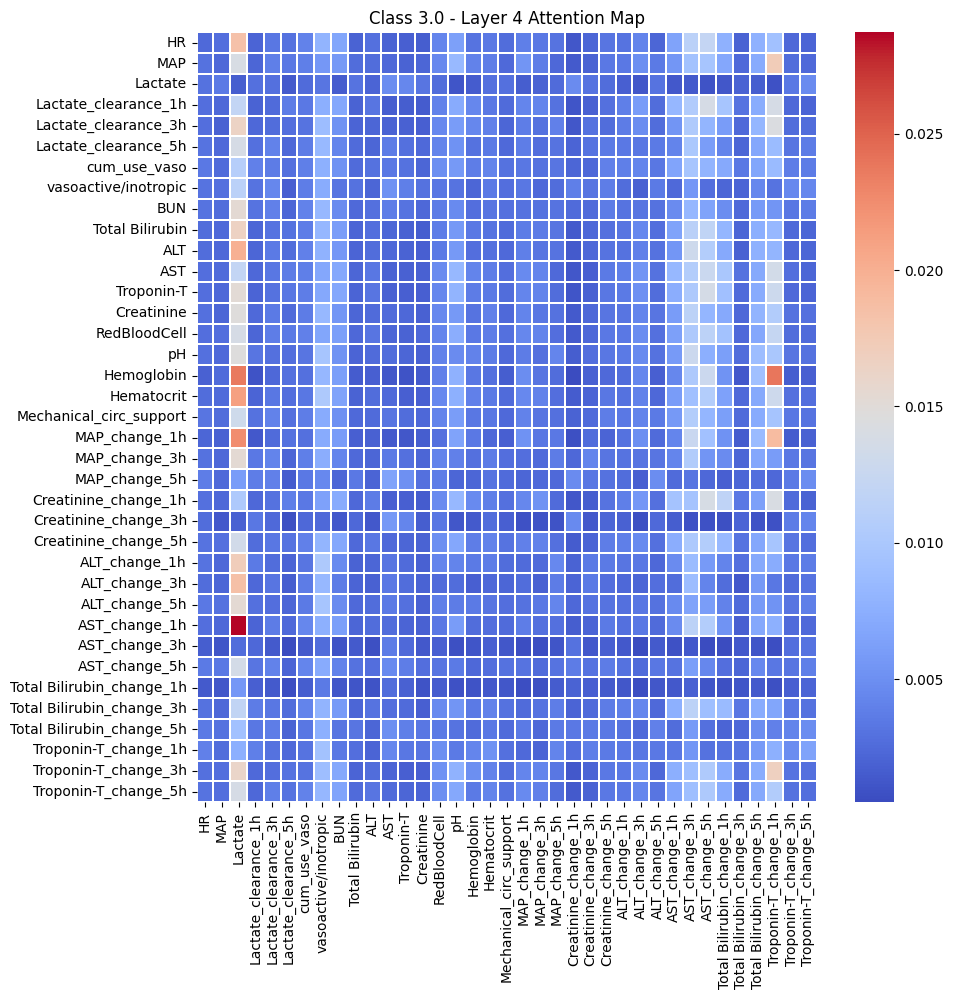

In [29]:
plot_attention_per_class(att, focus_columns, focus_columns_names)

In [15]:
import cohort_loader_new_version0229
from imp import reload
reload(cohort_loader_new_version0229)

case1 = cohort_loader_new_version0229.Case1Dataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
case1_loader = DataLoader(case1, batch_size=32, shuffle=True, drop_last=False)

case2 = cohort_loader_new_version0229.Case2Dataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
case2_loader = DataLoader(case2, batch_size=32, shuffle=True, drop_last=False)

case3 = cohort_loader_new_version0229.Case3Dataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
case3_loader = DataLoader(case3, batch_size=32, shuffle=True, drop_last=False)

case4 = cohort_loader_new_version0229.Case4Dataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
case4_loader = DataLoader(case4, batch_size=32, shuffle=True, drop_last=False)

Case
1.0    527044
4.0     16976
3.0     16824
2.0      5640
Name: count, dtype: int64
Annotation
no_circ      838
ambiguous    184
circ           8
Name: count, dtype: int64


In [16]:
import torch
from timeit import default_timer as timer
from tqdm import tqdm

def attention_map_case1(model_name, case1_loader, device):
    print('Start Getting the Attention positive(Case1)')
    start = timer()

    model_name.eval()
    att_maps = [] 

    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(case1_loader)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            _, att_valid = model_name(X_cat, X_num, True)

            att_maps.append(att_valid.cpu().numpy()) 
        final = np.concatenate(att_maps, axis = 1)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final

def attention_map_case2(model_name, case2_loader, device):
    print('Start Getting the Attention positive(Case2)')
    start = timer()

    model_name.eval()
    att_maps = [] 

    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(case2_loader)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            _, att_valid = model_name(X_cat, X_num, True)

            att_maps.append(att_valid.cpu().numpy()) 
        final = np.concatenate(att_maps, axis = 1)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final

def attention_map_case3(model_name, case3_loader, device):
    print('Start Getting the Attention positive(Case3)')
    start = timer()

    model_name.eval()
    att_maps = [] 

    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(case3_loader)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            _, att_valid = model_name(X_cat, X_num, True)

            att_maps.append(att_valid.cpu().numpy()) 
        final = np.concatenate(att_maps, axis = 1)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final

def attention_map_case4(model_name, case4_loader, device):
    print('Start Getting the Attention positive(Case4)')
    start = timer()

    model_name.eval()
    att_maps = [] 

    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(case4_loader)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            _, att_valid = model_name(X_cat, X_num, True)

            att_maps.append(att_valid.cpu().numpy())
      
        final = np.concatenate(att_maps, axis = 1)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final

case1_attn = attention_map_case1(model, case1_loader, device)
case2_attn = attention_map_case2(model, case2_loader, device)
case3_attn = attention_map_case3(model, case3_loader, device)
case4_attn = attention_map_case4(model, case4_loader, device)

Start Getting the Attention positive(Case1)


100%|██████████| 33/33 [00:01<00:00, 22.71it/s]


End, Time consume (min): 0.04104677166666685
Start Getting the Attention positive(Case2)


100%|██████████| 33/33 [00:00<00:00, 35.82it/s]


End, Time consume (min): 0.027753323333331536
Start Getting the Attention positive(Case3)


100%|██████████| 33/33 [00:00<00:00, 39.67it/s]


End, Time consume (min): 0.02527794500000103
Start Getting the Attention positive(Case4)


100%|██████████| 33/33 [00:00<00:00, 41.68it/s]


End, Time consume (min): 0.02510781166667281


In [17]:
att_dict = {1:[], 2:[], 3:[], 4:[]}
att_dict[1] = case1_attn
att_dict[2] = case2_attn
att_dict[3] = case3_attn
att_dict[4] = case4_attn

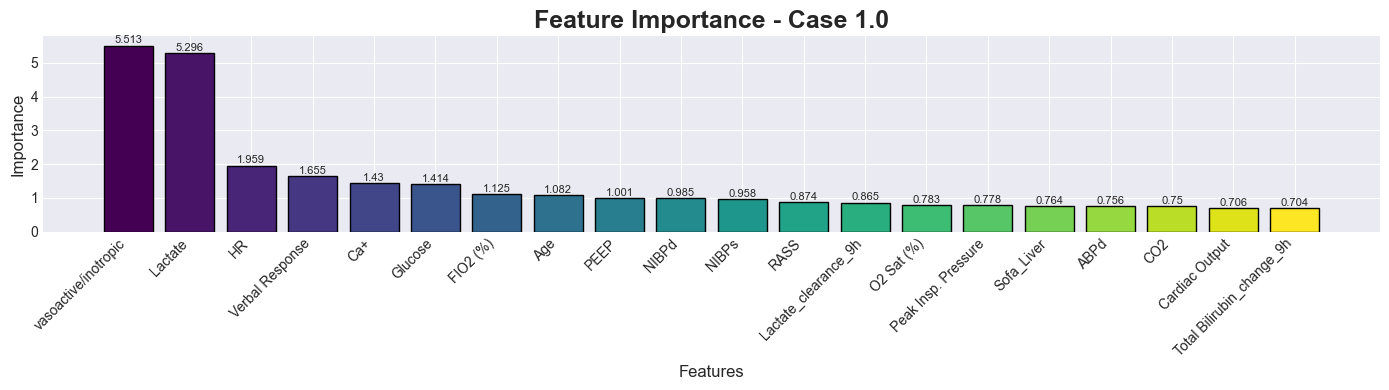

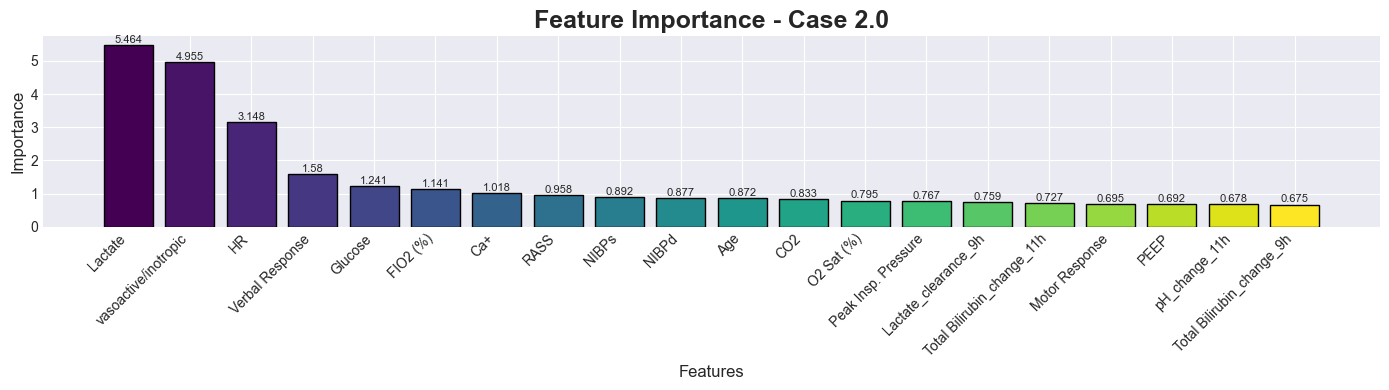

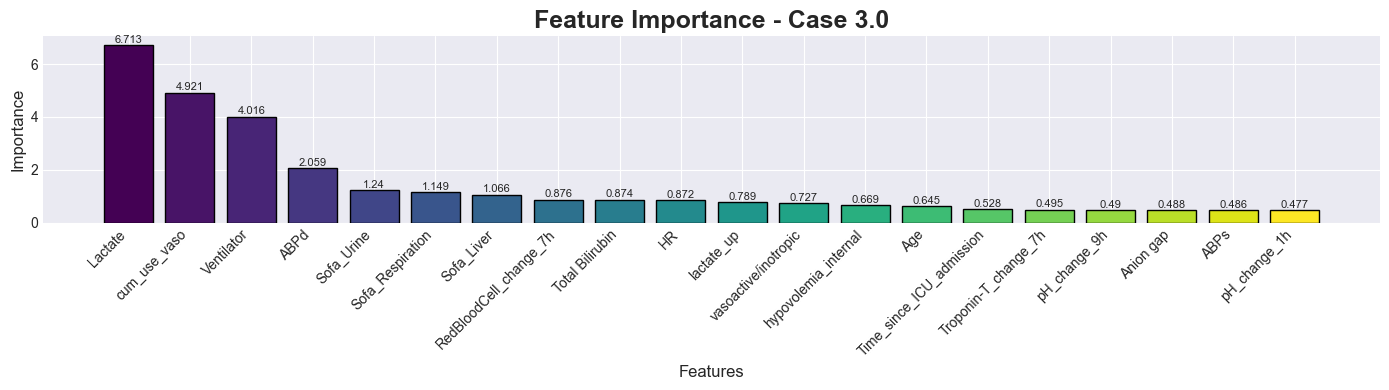

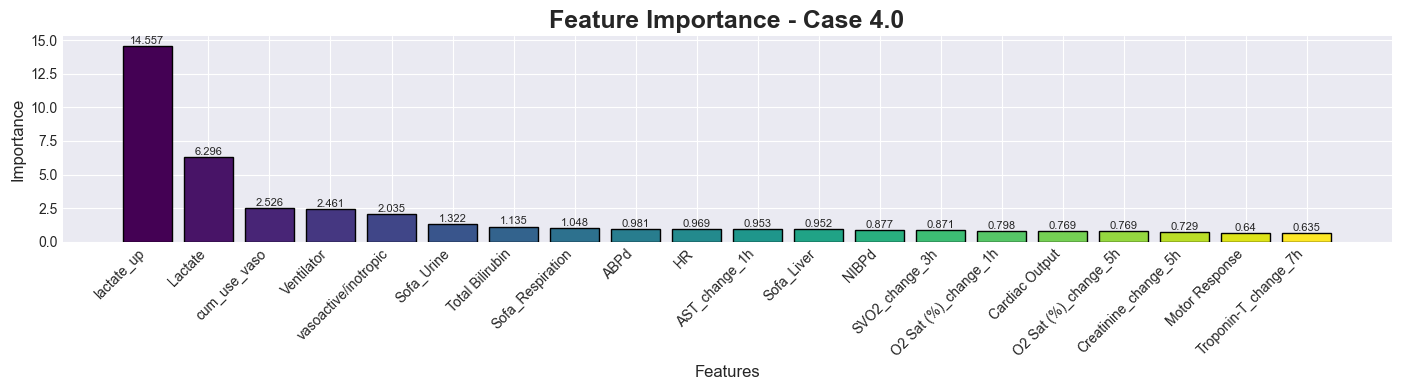

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# feature importance

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

heads = 5
layers = 4

columns = ['CLS_Token'] + mimic_train.df_cat.columns.tolist() + mimic_train.df_num.columns.tolist()
cls = [1.0, 2.0, 3.0, 4.0]

valid_indices = [i for i, col in enumerate(columns) if "_fillna" not in col and col != "progress" and col != "CRP" and col != "CLS_Token"]

for classes in cls:
    ps = []
    class_attention_map = att_dict[classes]  # (l, b, h, f, f)

    for sample in range(1030):
        get_cls_attentionmap = class_attention_map[:, sample, :, 0:1, :]  # (l, h, 1, f), sample에는 for 문의 결과로 1개의 샘플이 들어감
        sigma = get_cls_attentionmap.sum(axis=0).sum(axis=0)
        p = sigma / (heads * layers)
        ps.append(p)

    p = np.array(ps).sum(axis=0) / 1030 * 100
    
    if p.ndim == 2 and p.shape[0] == 1:
        p = p.ravel()

    p_filtered = p[valid_indices]
    top_feature_indices = np.argsort(p_filtered)[-20:][::-1]
    top_p_values = p_filtered[top_feature_indices]
    top_feature_names = [columns[valid_indices[i]] for i in top_feature_indices]

  
    plt.figure(figsize=(14, 4)) 
    bars = plt.bar(range(20), top_p_values, color=plt.cm.viridis(np.linspace(0, 1, 20)), edgecolor='black')
   
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom', fontsize=8)
    
    plt.title(f'Feature Importance - Case {classes}', fontsize=18, fontweight='bold')
    plt.xticks(ticks=range(20), labels=top_feature_names, rotation=45, ha="right", fontsize=10)  # x축 레이블 개선
    plt.ylabel('Importance', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()